# Analyis for the Dark Machines Collider Unsupervised Challenge
This notebook examines the results for the [hackathon dataset](https://zenodo.org/record/3961917#.X2tooJNKhQM). The methods were trained on background only samples and then applied to a mix of background and signal.

The goal of this notebook is to see which of the physics signals is easy to discover and which ones are hardest for the anomaly detection techniques.

Notebook author: Bryan Ostdiek (bostdiek at g.harvard.edu)

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.markers as mmark

from scipy.interpolate import interp1d

from os import walk, path

from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(f'Using numpy version {np.version.version}: known to work with 1.19.1')
print(f'Using pandas version {pd.__version__}: known to work with 1.1.1')

Using numpy version 1.19.1: known to work with 1.19.1
Using pandas version 1.1.1: known to work with 1.1.1


Some functions may not work with different versions of numpy or pandas

In [3]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

# Load Data
## Auto Encoder 
Submission by Baptiste Ravina. Details on the method can be found in section 4.1 of the paper.

In [4]:
AE = pd.read_csv('../data/AE.csv')

AEModels = list(AE['Model'].unique())
print(len(AEModels))

1


## Variational Auto Encoders
Submission by Luc Hendriks. Details on the method can be found in section 4.2 of the paper.

In [5]:
VAEs = pd.read_csv('../data/VAE.csv')

VAEModels = list(VAEs['Model'].unique())
print(len(VAEModels))

140


## Deep Set VAE
Submission by Bryan Ostdiek. Details on the method can be found in section 4.3 of the paper.

In [6]:
DeepSetVAE = pd.read_csv('../data/DeepSetVAE.csv')

DeepSetVAEModels = list(DeepSetVAE['Model'].unique())
print(len(DeepSetVAEModels))

4


## ConvVAE with and without flows.
Submission by Pratik Jawahar. Details on the methods can be found in sections 4.4 (without flows) and 4.5 (with flows).

In [7]:
ConvVAE = pd.read_csv('../data/ConvVAE_and_Flows.csv')

ConvVAEModels = list(ConvVAE['Model'].unique())
print(len(ConvVAEModels))

7


## CNN-(B)VAE
Submissions by Joe Davies. Information can be found in section 4.6 of the paper.

In [8]:
CNNVAE = pd.read_csv('../data/CNN_VAE.csv')
CNNBVAE = pd.read_csv('../data/CNN_BVAE.csv')

CNNVAEModels = list(CNNVAE['Model'].unique())
print(len(CNNVAEModels))
CNNBVAEModels = list(CNNBVAE['Model'].unique())
print(len(CNNBVAEModels))

1
1


## Density Estimation
Submission by Alessandro Morandini. Information can be found in section 4.7 of the paper.

In [9]:
KDE = pd.read_csv('../data/KDE.csv')

KDEModels = list(KDE['Model'].unique())
print(len(KDEModels))

36


## Flows
Submission by Luc Hendriks. Information can be found in section 4.8 of the paper.

In [10]:
Flows = pd.read_csv('../data/Flow.csv')

FlowsModels = list(Flows['Model'].unique())
print(len(FlowsModels))

2


## Deep SVDD
Submission by Luc Hendriks. Infromation can be found in section 4.9 of the paper.

In [11]:
DeepSVDD = pd.read_csv('../data/DeepSVDD.csv')

DeepSVDDModels = list(DeepSVDD['Model'].unique())
print(len(DeepSVDDModels))

80


## Combinations of Flows and Deep SVDD or VAE
Submission by Luc Hendriks. Information can be found in section 4.10 of the paper.

In [12]:
Combined = pd.read_csv('../data/Combined.csv')

CombinedModels = list(Combined['Model'].unique())
print(len(CombinedModels))

8


## DAGMM
Submission by Roberto Ruiz. Information can be found in section 4.11 of the paper.

In [13]:
DAGMM = pd.read_csv('../data/DAGMM.csv')

DAGMMModels = list(DAGMM['Model'].unique())
print(len(DAGMMModels))

384


## ALAD
Submission by Roberto Ruiz. Information can be found in section 4.12 of the paper.

In [14]:
ALAD = pd.read_csv('../data/ALAD.csv')

ALADModels = list(ALAD['Model'].unique())
print(len(ALADModels))

96


## Latent Space Methods
Submission by Adam Leinweber. Information can be found in section 4.13 of the paper.

In [15]:
Latent = pd.read_csv('../data/MethodsInLatentSpaceOfVAE.csv')

LatentModels = list(Latent['Model'].unique())
print(len(LatentModels))

288


## Concatenate into a single data frame

In [16]:
names = ['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
AllCombined = np.array(AE[names])
AllCombined = np.vstack([AllCombined, VAEs[names]])
AllCombined = np.vstack([AllCombined, DeepSetVAE[names]])
AllCombined = np.vstack([AllCombined, ConvVAE[names]])
AllCombined = np.vstack([AllCombined, CNNVAE[names]])
AllCombined = np.vstack([AllCombined, CNNBVAE[names]])
AllCombined = np.vstack([AllCombined, KDE[names]])
AllCombined = np.vstack([AllCombined, Flows[names]])
AllCombined = np.vstack([AllCombined, DeepSVDD[names]])  
AllCombined = np.vstack([AllCombined, Combined[names]]) 
AllCombined = np.vstack([AllCombined, DAGMM[names]])
AllCombined = np.vstack([AllCombined, ALAD[names]])
AllCombined = np.vstack([AllCombined, Latent[names]])
AllCombined = pd.DataFrame(AllCombined, columns=names)

In [17]:
AllCombined

Signal                     Model Chan       AUC  \
0      stop2b1000_neutralino300                  SimpleAE    1     0.872   
1      monojet_Zp2000.0_DM_50.0                  SimpleAE    1     0.724   
2                 monotop_200_A                  SimpleAE    1     0.714   
3       glgl1400_neutralino1100                  SimpleAE    1      0.79   
4                   stlp_st1000                  SimpleAE    1     0.968   
...                         ...                       ...  ...       ...   
35547      sqsq1_sq1400_neut800    LS_Average_4_0.1_10000    3  0.795075   
35548      sqsq1_sq1400_neut800     LS_Average_4_1.0_1000    3  0.805776   
35549      sqsq1_sq1400_neut800    LS_Average_4_1.0_10000    3  0.765942   
35550      sqsq1_sq1400_neut800   LS_Average_4_1e-05_1000    3  0.875899   
35551      sqsq1_sq1400_neut800  LS_Average_4_1e-05_10000    3  0.880063   

            1e-2        1e-3        1e-4  
0          0.211       0.097       0.047  
1          0.106       0.045       0.015  
2           0.13       0.077       0.037  
3           0.15       0.083       0.043  
4          0.703       0.525       0.314  
...          ...         ...         ...  
35547  0.0478249  0.00681342  0.00222746  
35548    0.16326    0.019261  0.00393082  
35549   0.137317   0.0259434  0.00366876  
35550   0.200996   0.0476939   0.0086478  
35551   0.210168   0.0587002   0.0125786  

[35552 rows x 7 columns]

Check to make sure all models have results for all of the signals.

In [18]:
incomplete_models = []
for Chan in ['1', '2a', '2b', '3']:
    for mod in list(AllCombined['Model'].unique()):
        if mod not in list(AllCombined[AllCombined['Chan'] == Chan]['Model']):
            print(f'Missing Chan {Chan} for {mod}')
            incomplete_models.append(mod)

print(f'....Dropping {len(incomplete_models)} incomplete models')
AllCombined = AllCombined[~AllCombined['Model'].isin(incomplete_models)]

print(f'\nResults are computed for {AllCombined.Model.unique().shape[0]} models')

Missing Chan 3 for DeepSVDD_Reduced_d377
Missing Chan 3 for DeepSVDD_C0_d377
Missing Chan 3 for DeepSVDD_C1_d377
Missing Chan 3 for DeepSVDD_C2_d377
Missing Chan 3 for DeepSVDD_C3_d377
Missing Chan 3 for DeepSVDD_C4_d377
Missing Chan 3 for DeepSVDD_C10_d377
Missing Chan 3 for DeepSVDD_C25_d377
....Dropping 8 incomplete models

Results are computed for 1040 models


# Analyze each signal across all anomaly detection techniques

In [19]:
AllSigs = list(AllCombined['Signal'].unique())

Here we will show box-and-whiskers plots for all of the different anomaly detection methods on a given BSM physics signal. Thus each data point represents a single model.

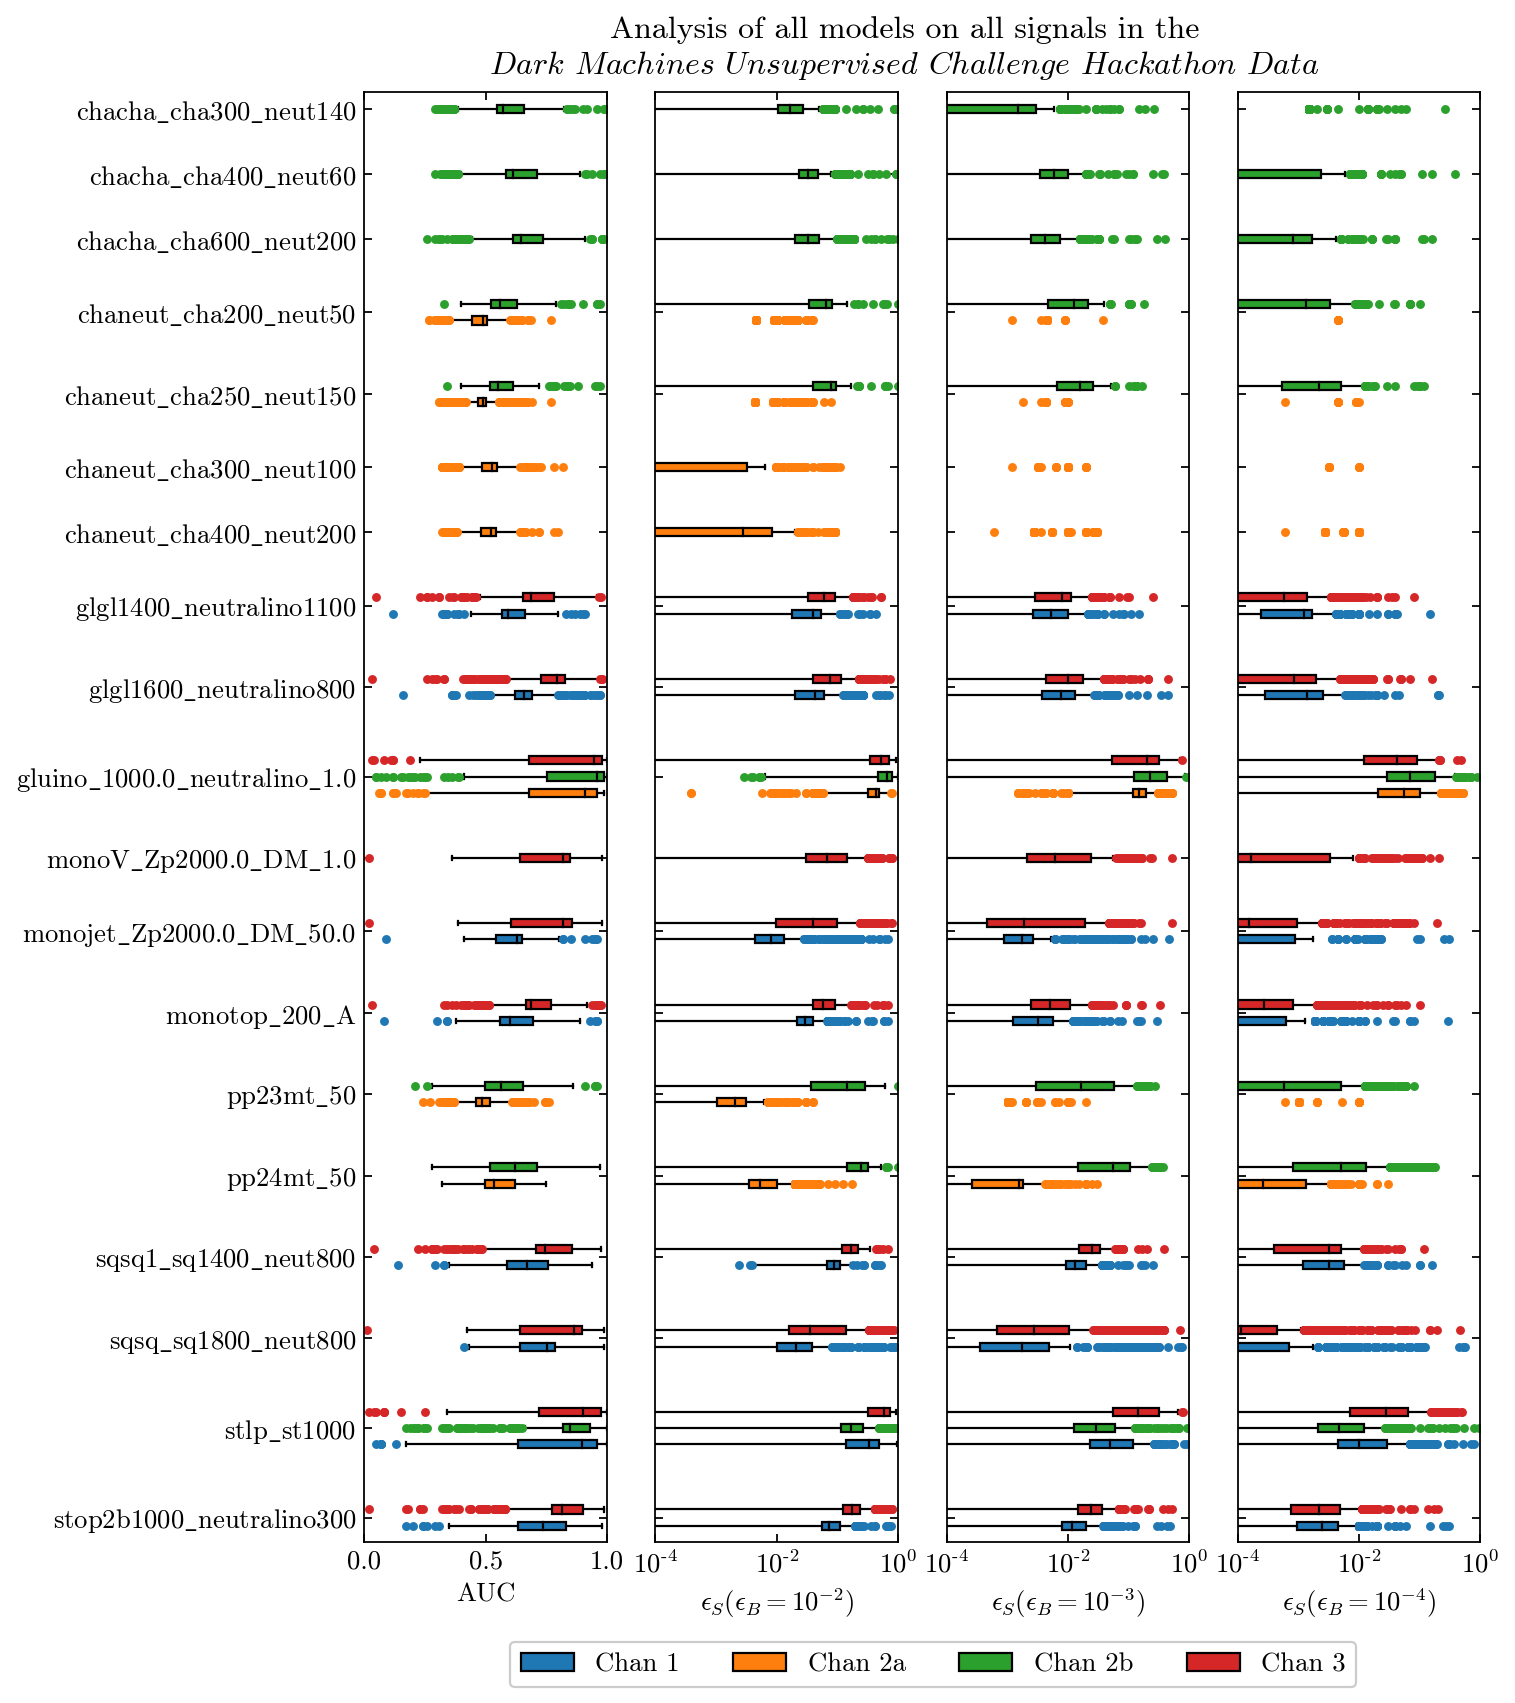

In [20]:
counter = 0
yvs = []
ListAUC = []
List1m2 = []
List1m3 = []
List1m4 = []
my_yticks = []
my_ynames = []
mycolors = []
colordict = {'1': 'C0', '2a': 'C1', '2b': 'C2', '3': 'C3'}
plt.figure(figsize=(9, 12))
for sig in np.sort(AllSigs)[::-1]:
    tmp_df = AllCombined[AllCombined['Signal'] == sig]
    channels = list(tmp_df.Chan.unique())
    lc = len(channels)
    
    tmp_yn = []
    for i, chan in enumerate(channels):
        tmp_df = AllCombined[(AllCombined['Signal'] == sig) & (AllCombined['Chan'] == chan)]
        
        ListAUC.append(tmp_df['AUC'])
        List1m2.append(tmp_df['1e-2'])
        List1m3.append(tmp_df['1e-3'])
        List1m4.append(tmp_df['1e-4'])
        yvs.append(counter)
        tmp_yn.append(counter)
        counter += 1
        mycolors.append(colordict[chan])
    counter += 3
    my_yticks.append(np.mean(tmp_yn))
    my_ynames.append(sig.replace('_', '$\_$'))
plt.subplot(1, 4, 1)    
bbox1 = plt.boxplot(np.array(ListAUC).T,
            vert=False,
            manage_ticks=False,
            patch_artist=True,
            medianprops={'color':'k'},
            positions=yvs
           )
plt.xlim(0, 1)
plt.yticks(my_yticks, my_ynames)
plt.xlabel('AUC')
for patch, flier, color in zip(bbox1['boxes'], bbox1['fliers'], mycolors):
    patch.set_facecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markersize(3)
    flier.set_markeredgecolor(color)
plt.ylim(min(yvs)-1, max(yvs)+1)

plt.subplot(1, 4, 2)    
bbox1 = plt.boxplot(np.array(List1m2).T,
            vert=False,
            manage_ticks=False,
            patch_artist=True,
            medianprops={'color':'k'},
            positions=yvs
           )
plt.xscale('log')
plt.xlim(1e-4, 1)
plt.yticks(my_yticks, [])
plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-2})$')
for patch, flier, color in zip(bbox1['boxes'], bbox1['fliers'], mycolors):
    patch.set_facecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markersize(3)
    flier.set_markeredgecolor(color)
plt.ylim(min(yvs)-1, max(yvs)+1)

plt.subplot(1, 4, 3)    
bbox1 = plt.boxplot(np.array(List1m3).T,
            vert=False,
            manage_ticks=False,
            patch_artist=True,
            medianprops={'color':'k'},
            positions=yvs
           )
plt.xscale('log')
plt.xlim(1e-4, 1)
plt.yticks(my_yticks, [])
plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-3})$')
for patch, flier, color in zip(bbox1['boxes'], bbox1['fliers'], mycolors):
    patch.set_facecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markersize(3)
    flier.set_markeredgecolor(color)
plt.ylim(min(yvs)-1, max(yvs)+1)

plt.subplot(1, 4, 4)    
bbox1 = plt.boxplot(np.array(List1m4).T,
            vert=False,
            manage_ticks=False,
            patch_artist=True,
            medianprops={'color':'k'},
            positions=yvs
           )
plt.xscale('log')
plt.xlim(1e-4, 1)
plt.yticks(my_yticks, [])
for patch, flier, color in zip(bbox1['boxes'], bbox1['fliers'], mycolors):
    patch.set_facecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markerfacecolor(color)
    flier.set_markersize(3)
    flier.set_markeredgecolor(color)
plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-4})$')
plt.ylim(min(yvs)-1, max(yvs)+1)
    
    
legend_elements = [Patch(facecolor='C0', edgecolor='k',
                         label='Chan 1'),
                   Patch(facecolor='C1', edgecolor='k',
                         label='Chan 2a'),
                   Patch(facecolor='C2', edgecolor='k',
                         label='Chan 2b'),
                   Patch(facecolor='C3', edgecolor='k',
                         label='Chan 3')
                  ]
plt.legend(handles=legend_elements, 
           loc=(-3, -0.1), 
           labelspacing=1,
           ncol=4,
           facecolor='white',
           framealpha=1,
#            markerscale=100,
           frameon=True)
    
plt.suptitle('Analysis of all models on all signals in the\n$Dark$ $Machines$ $Unsupervised$ $Challenge$ $Hackathon$ $Data$', y=0.92)
plt.savefig('../figures/AllModelsAllSignals.pdf', bbox_inches='tight')
plt.show()


## Top models for each signal
Now we look individually at each signal and find the top 5 models for each figure of merit.

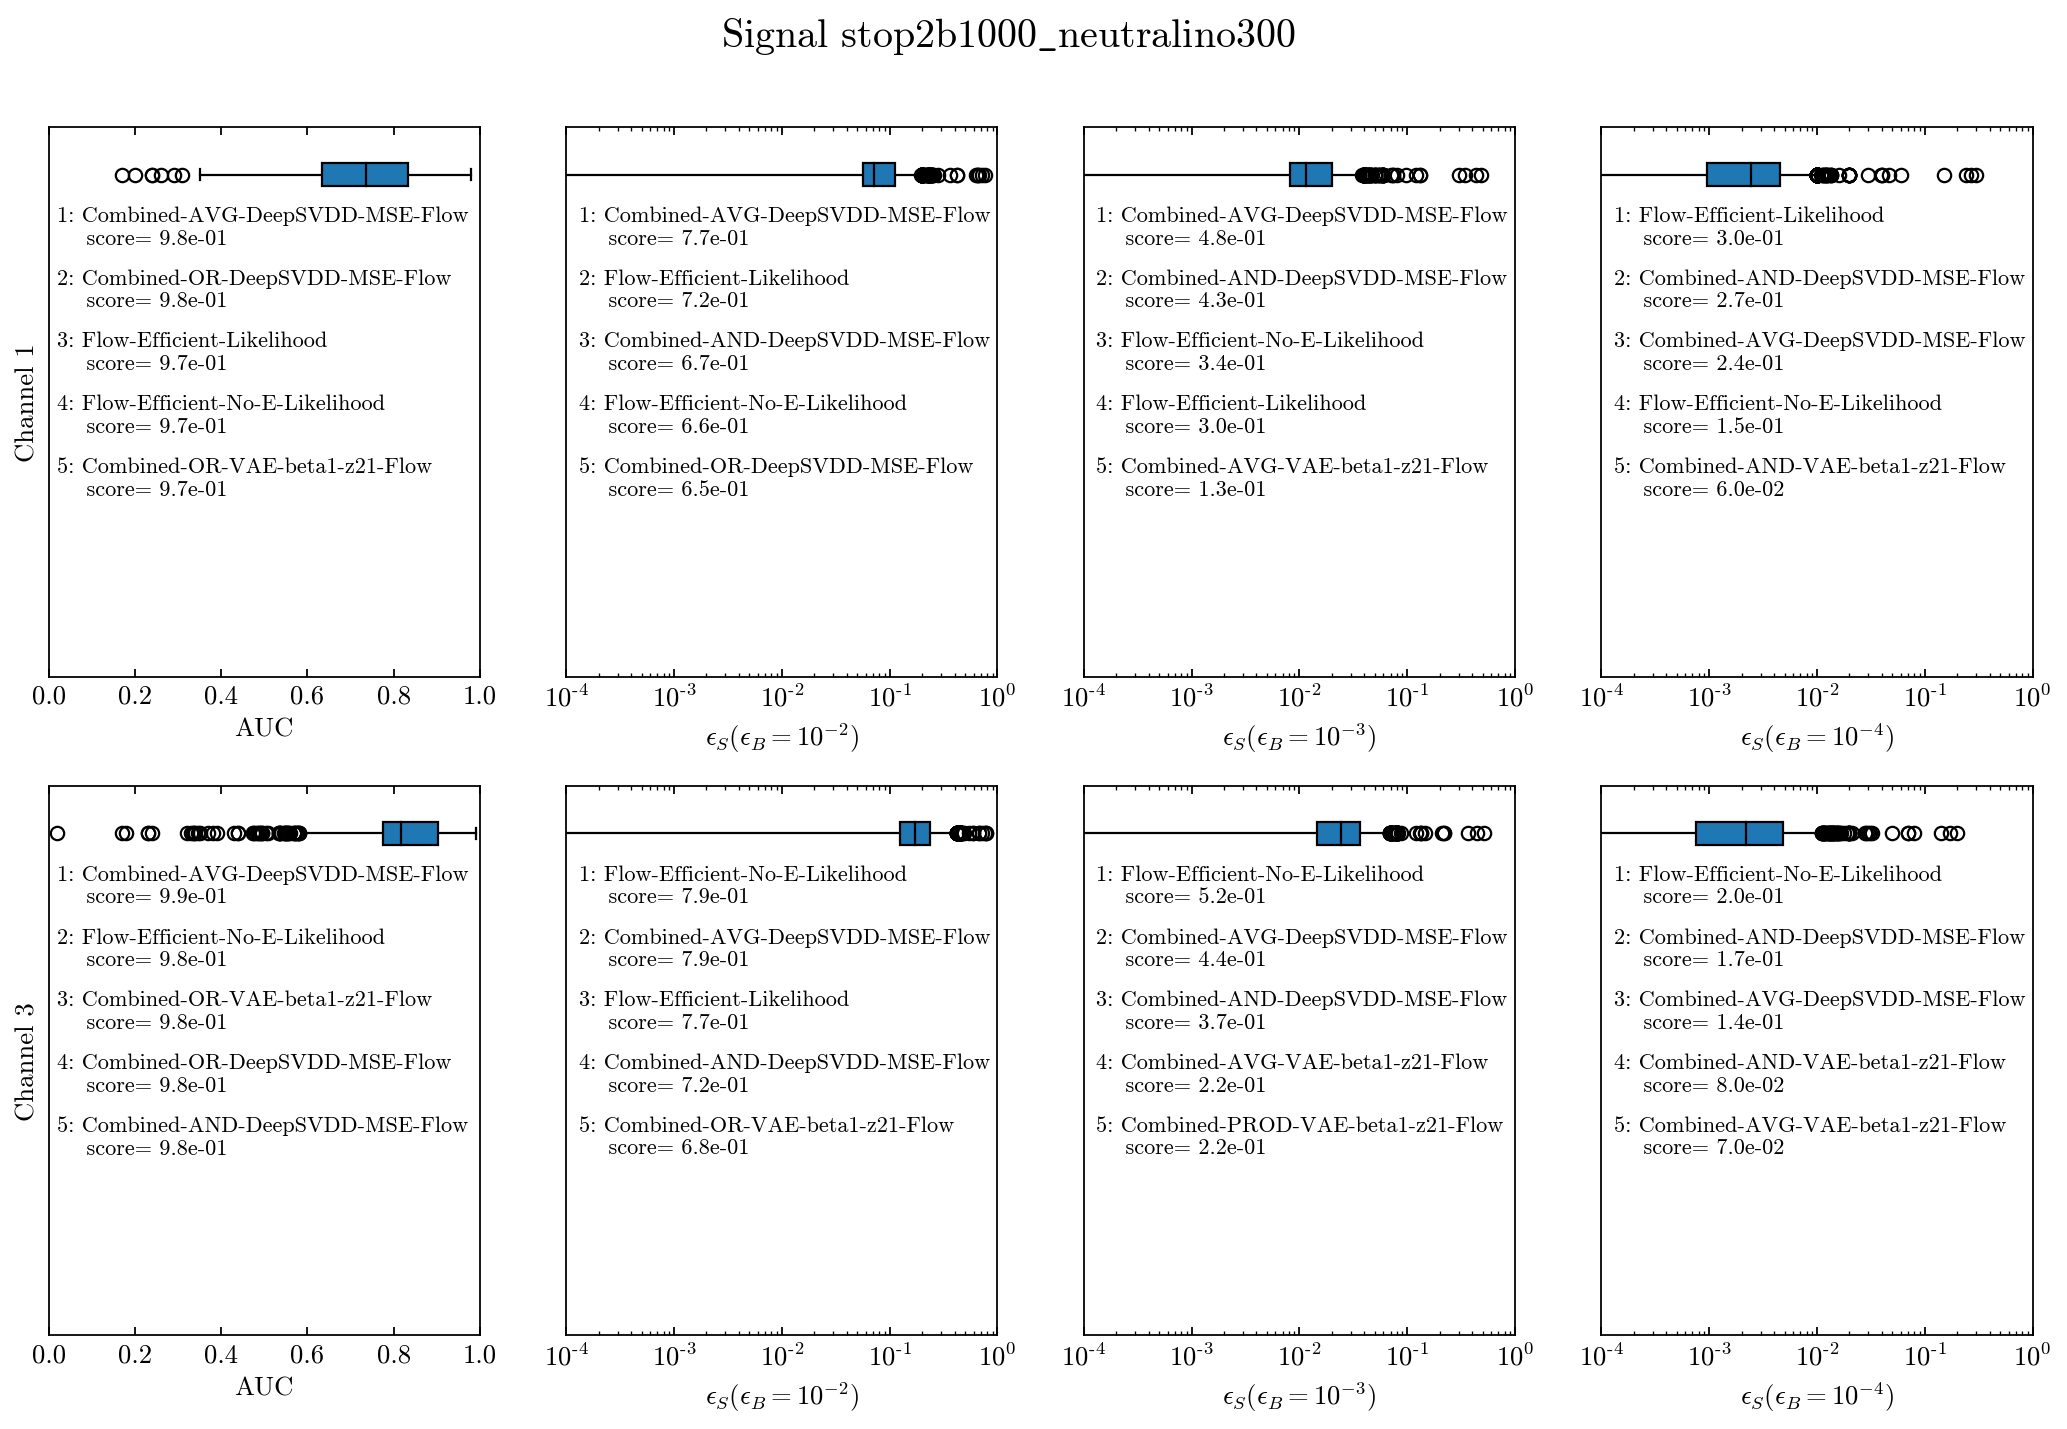

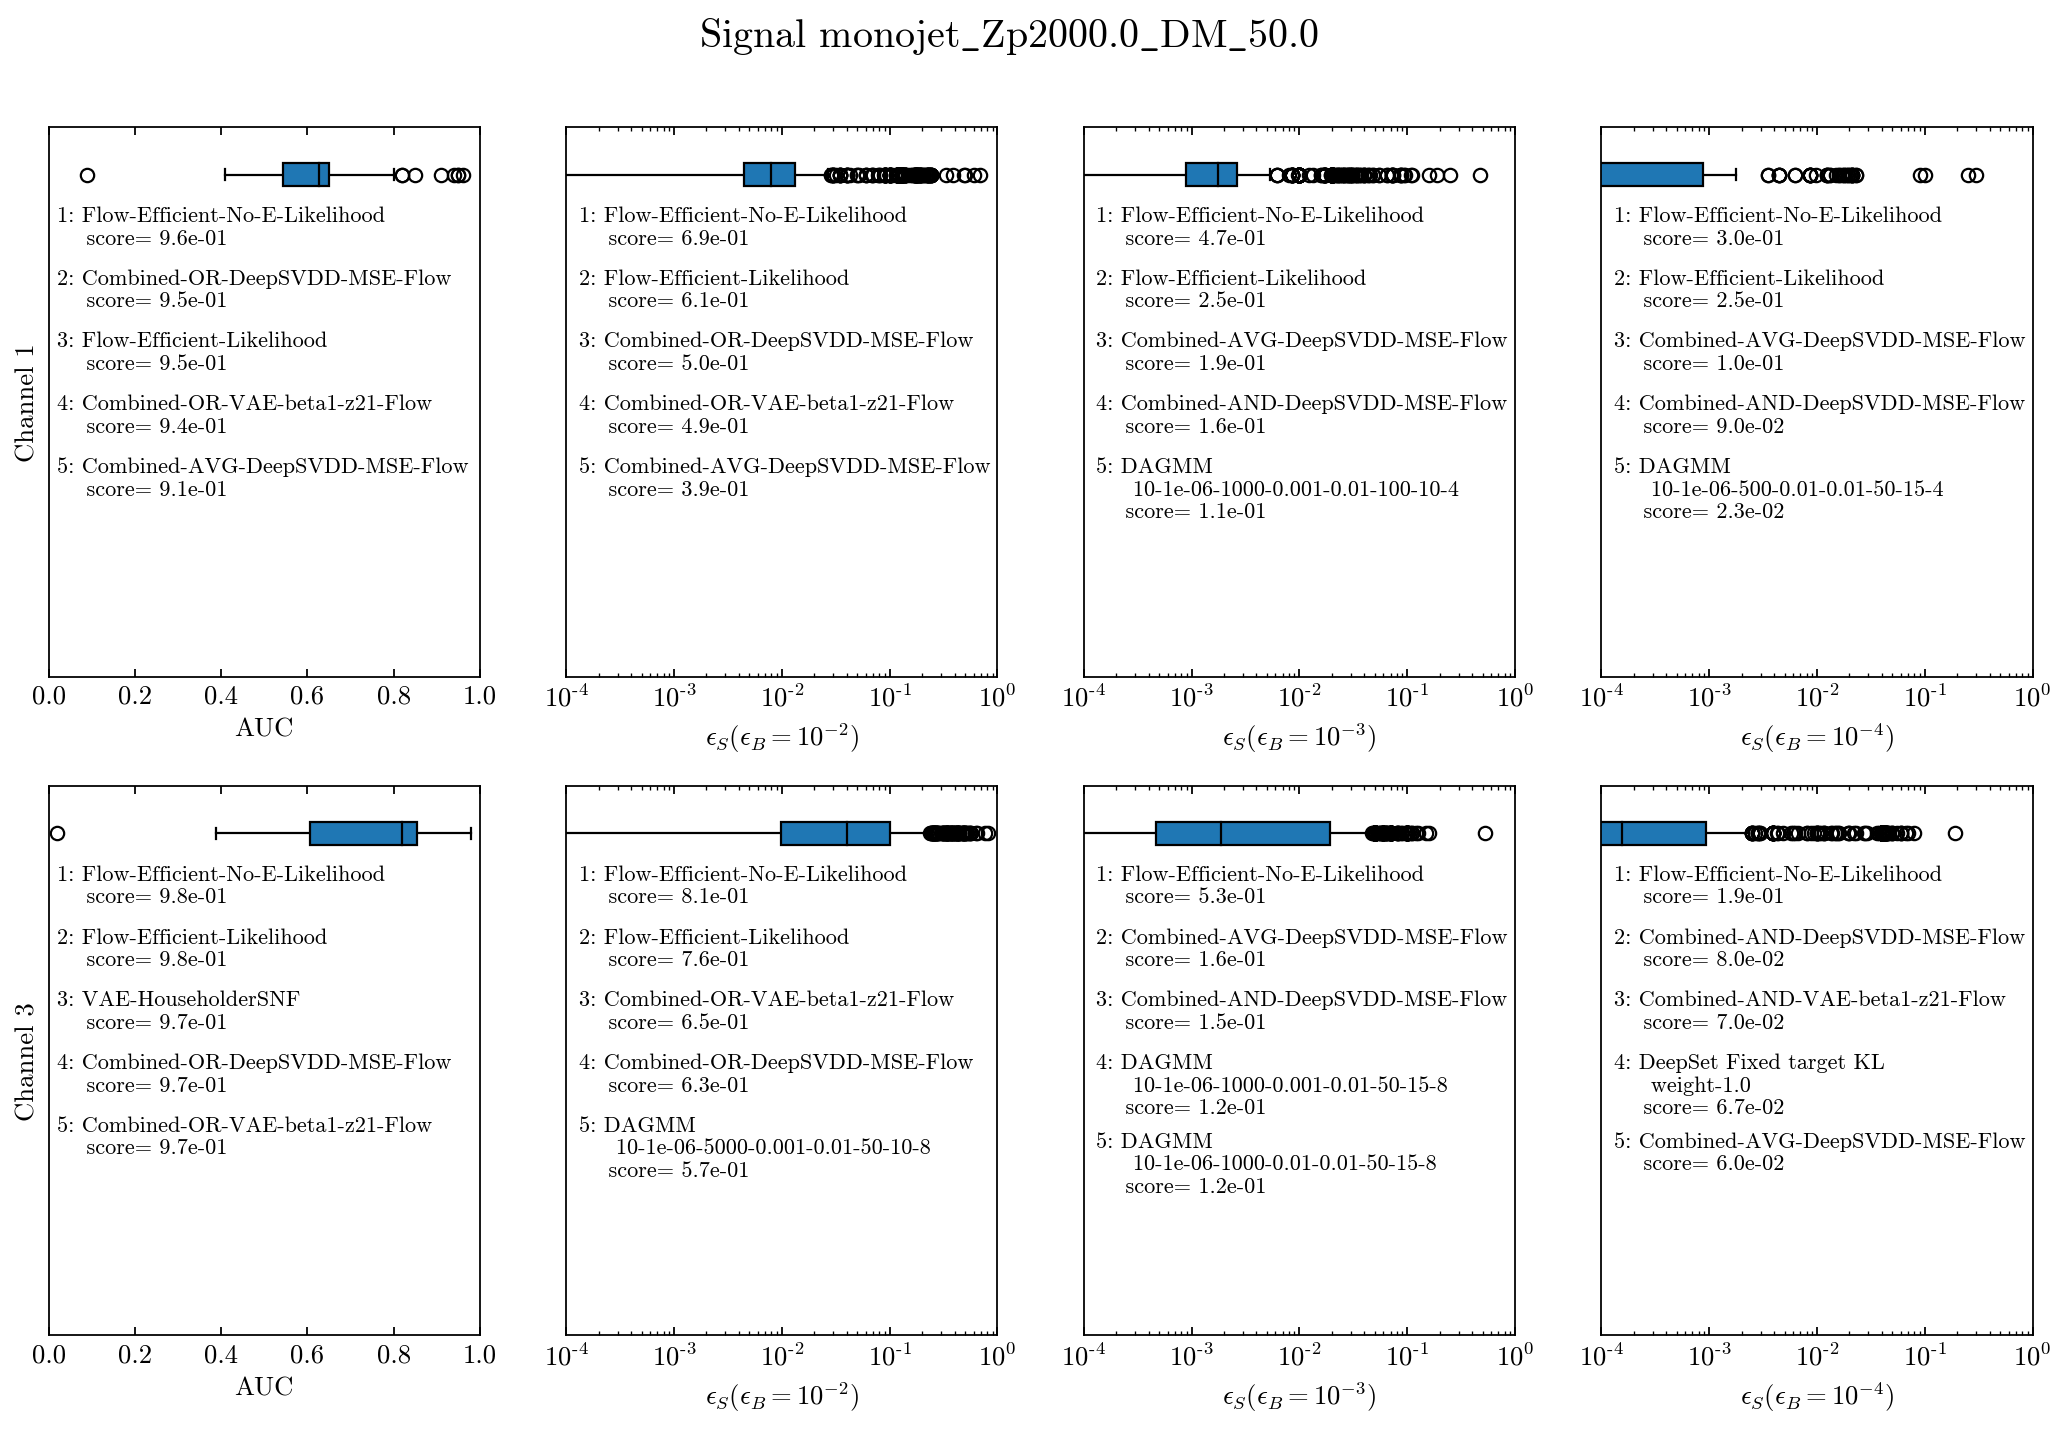

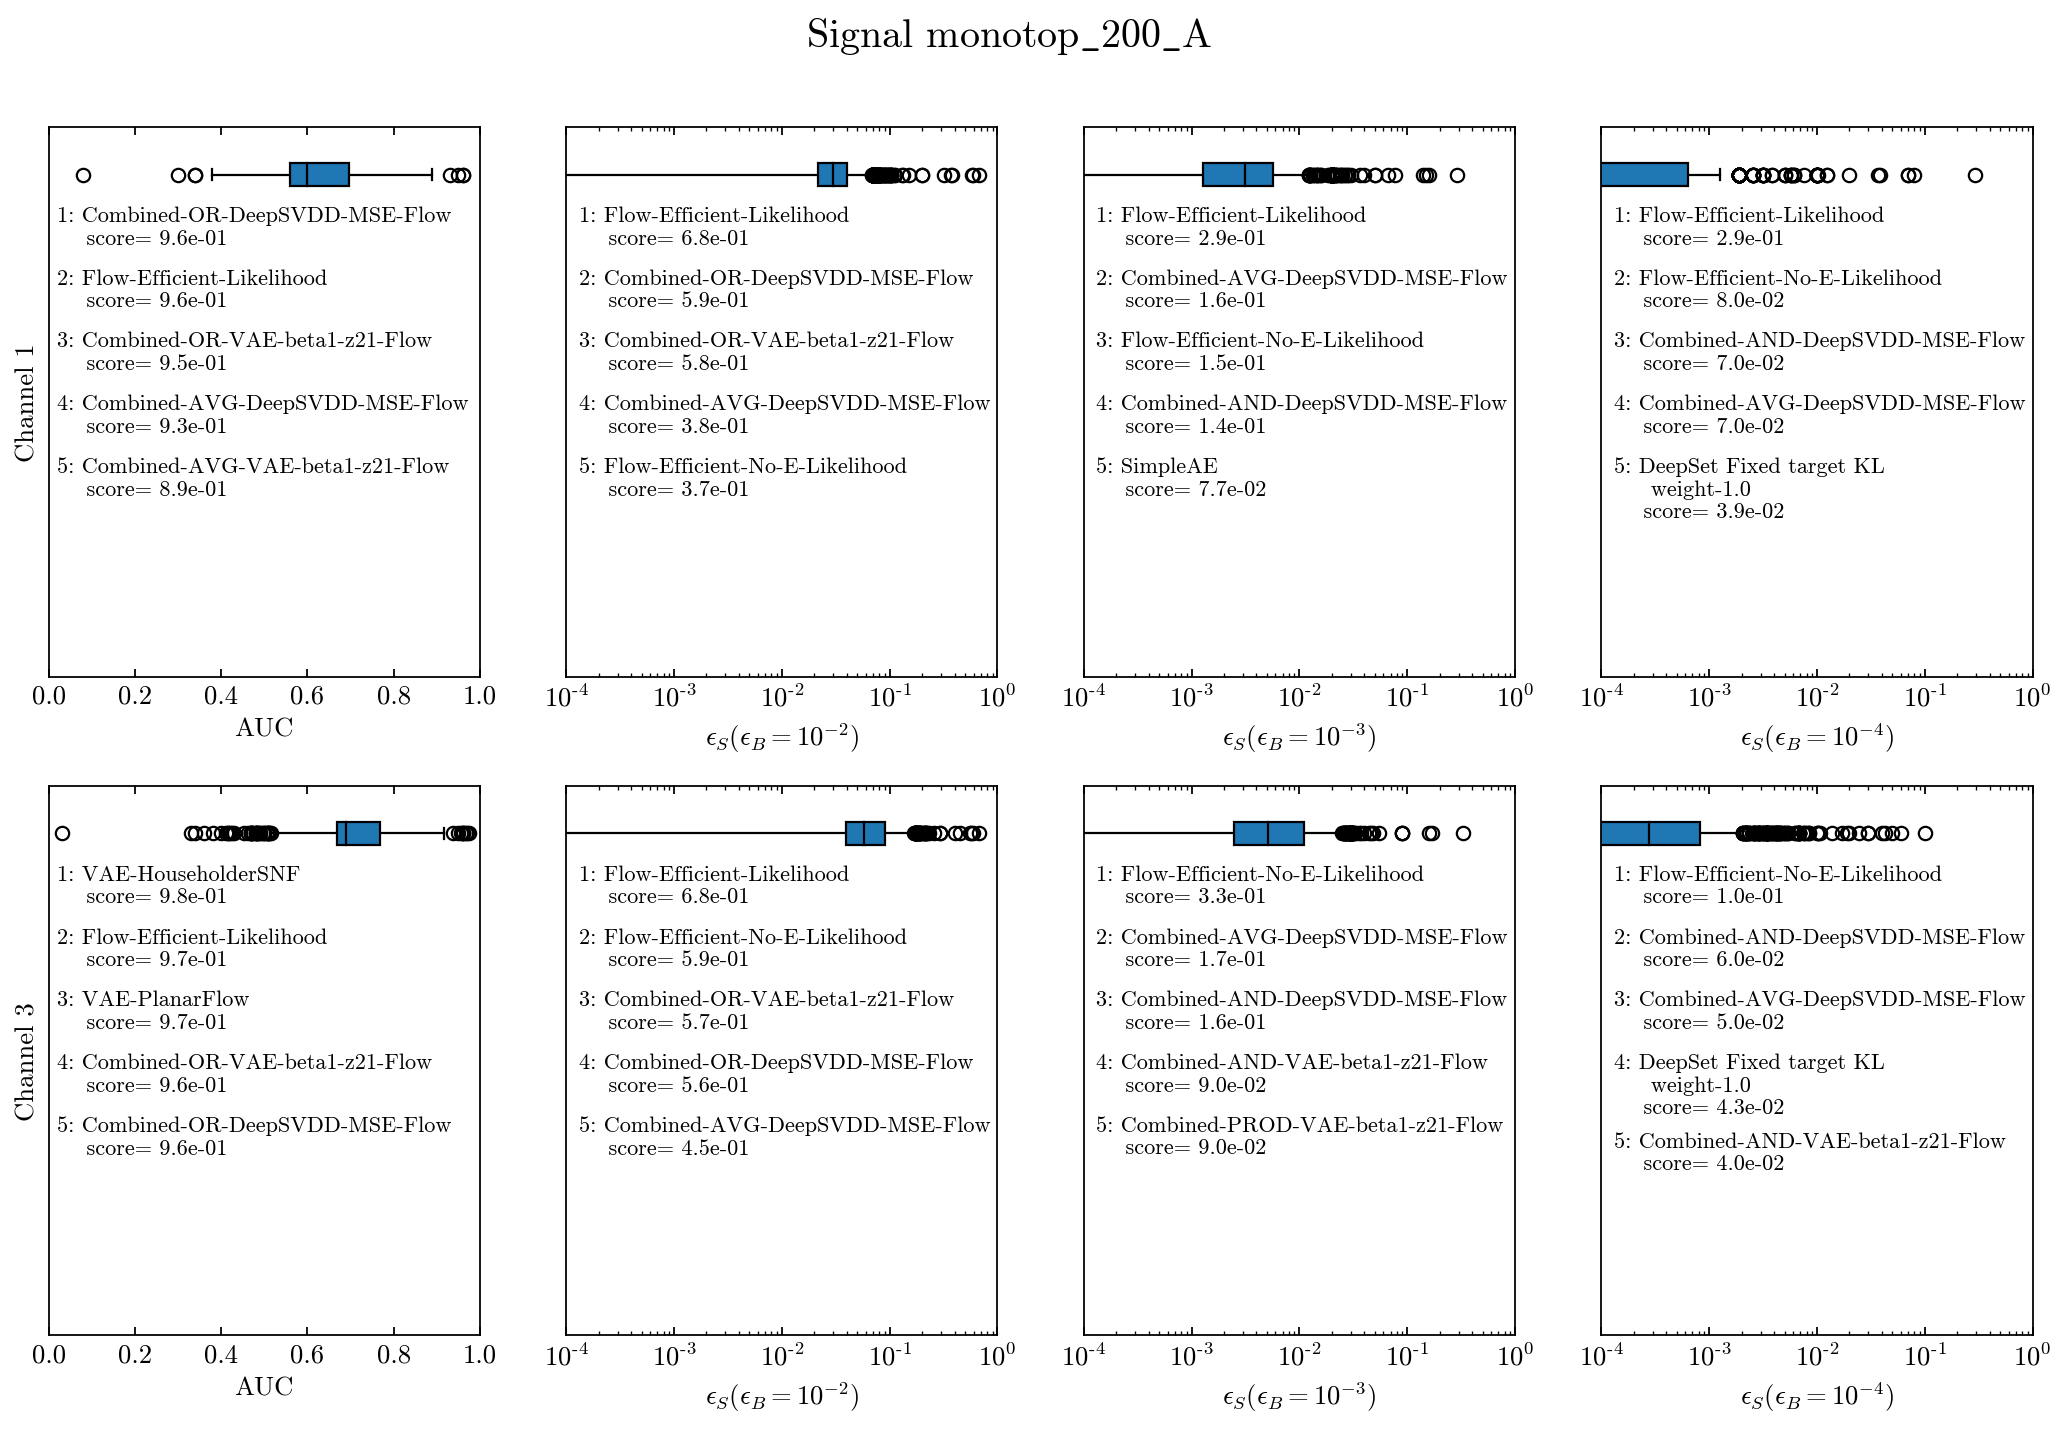

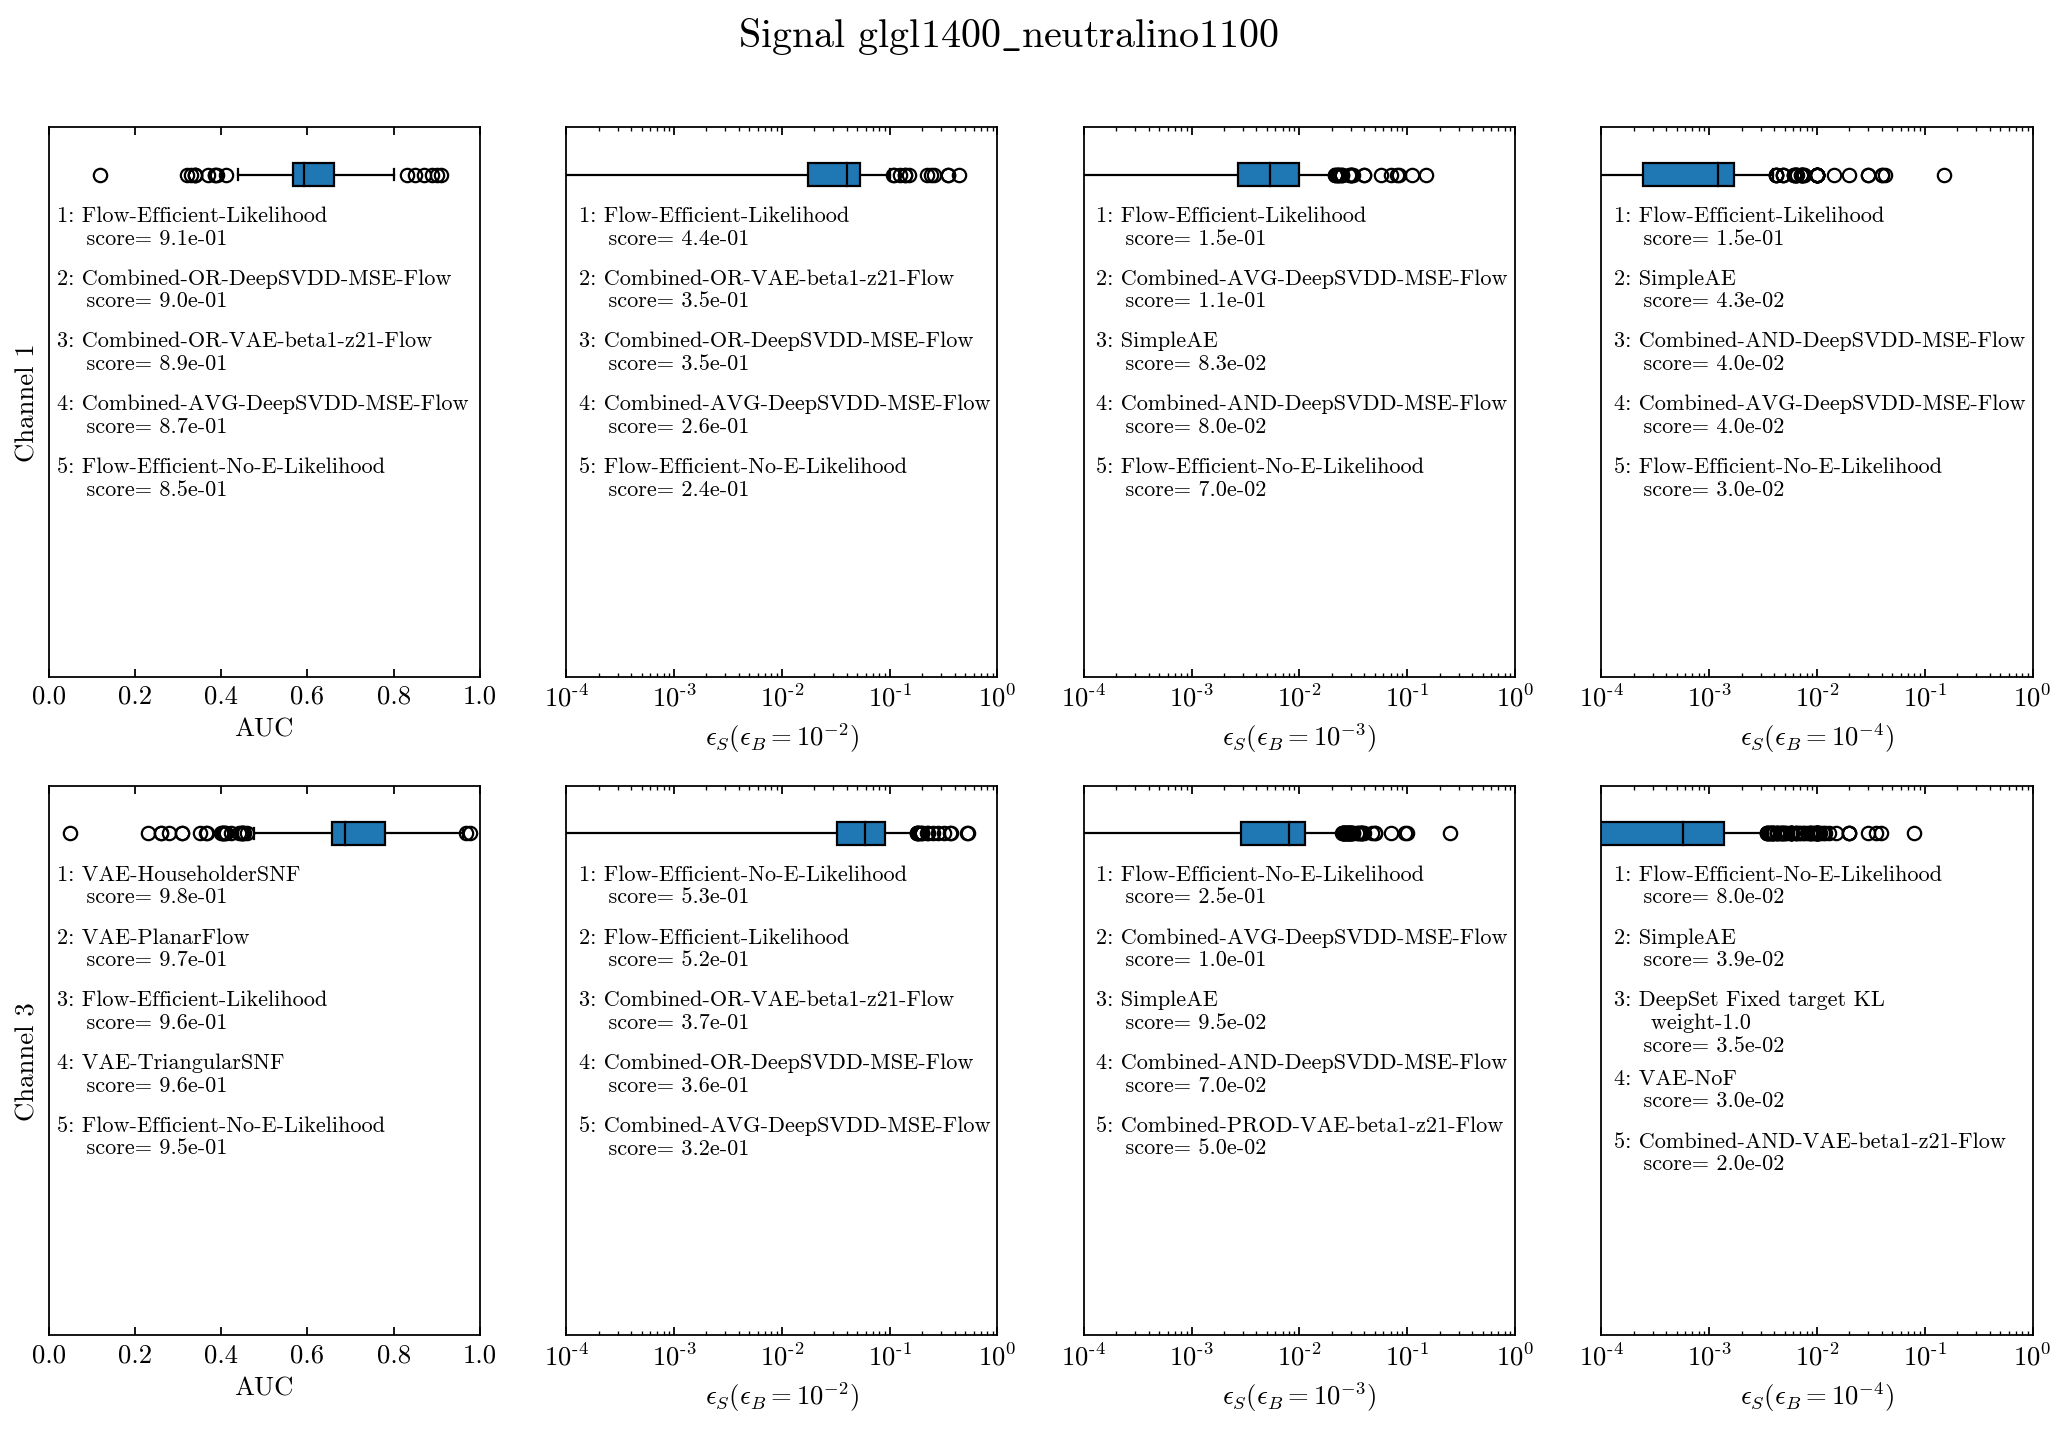

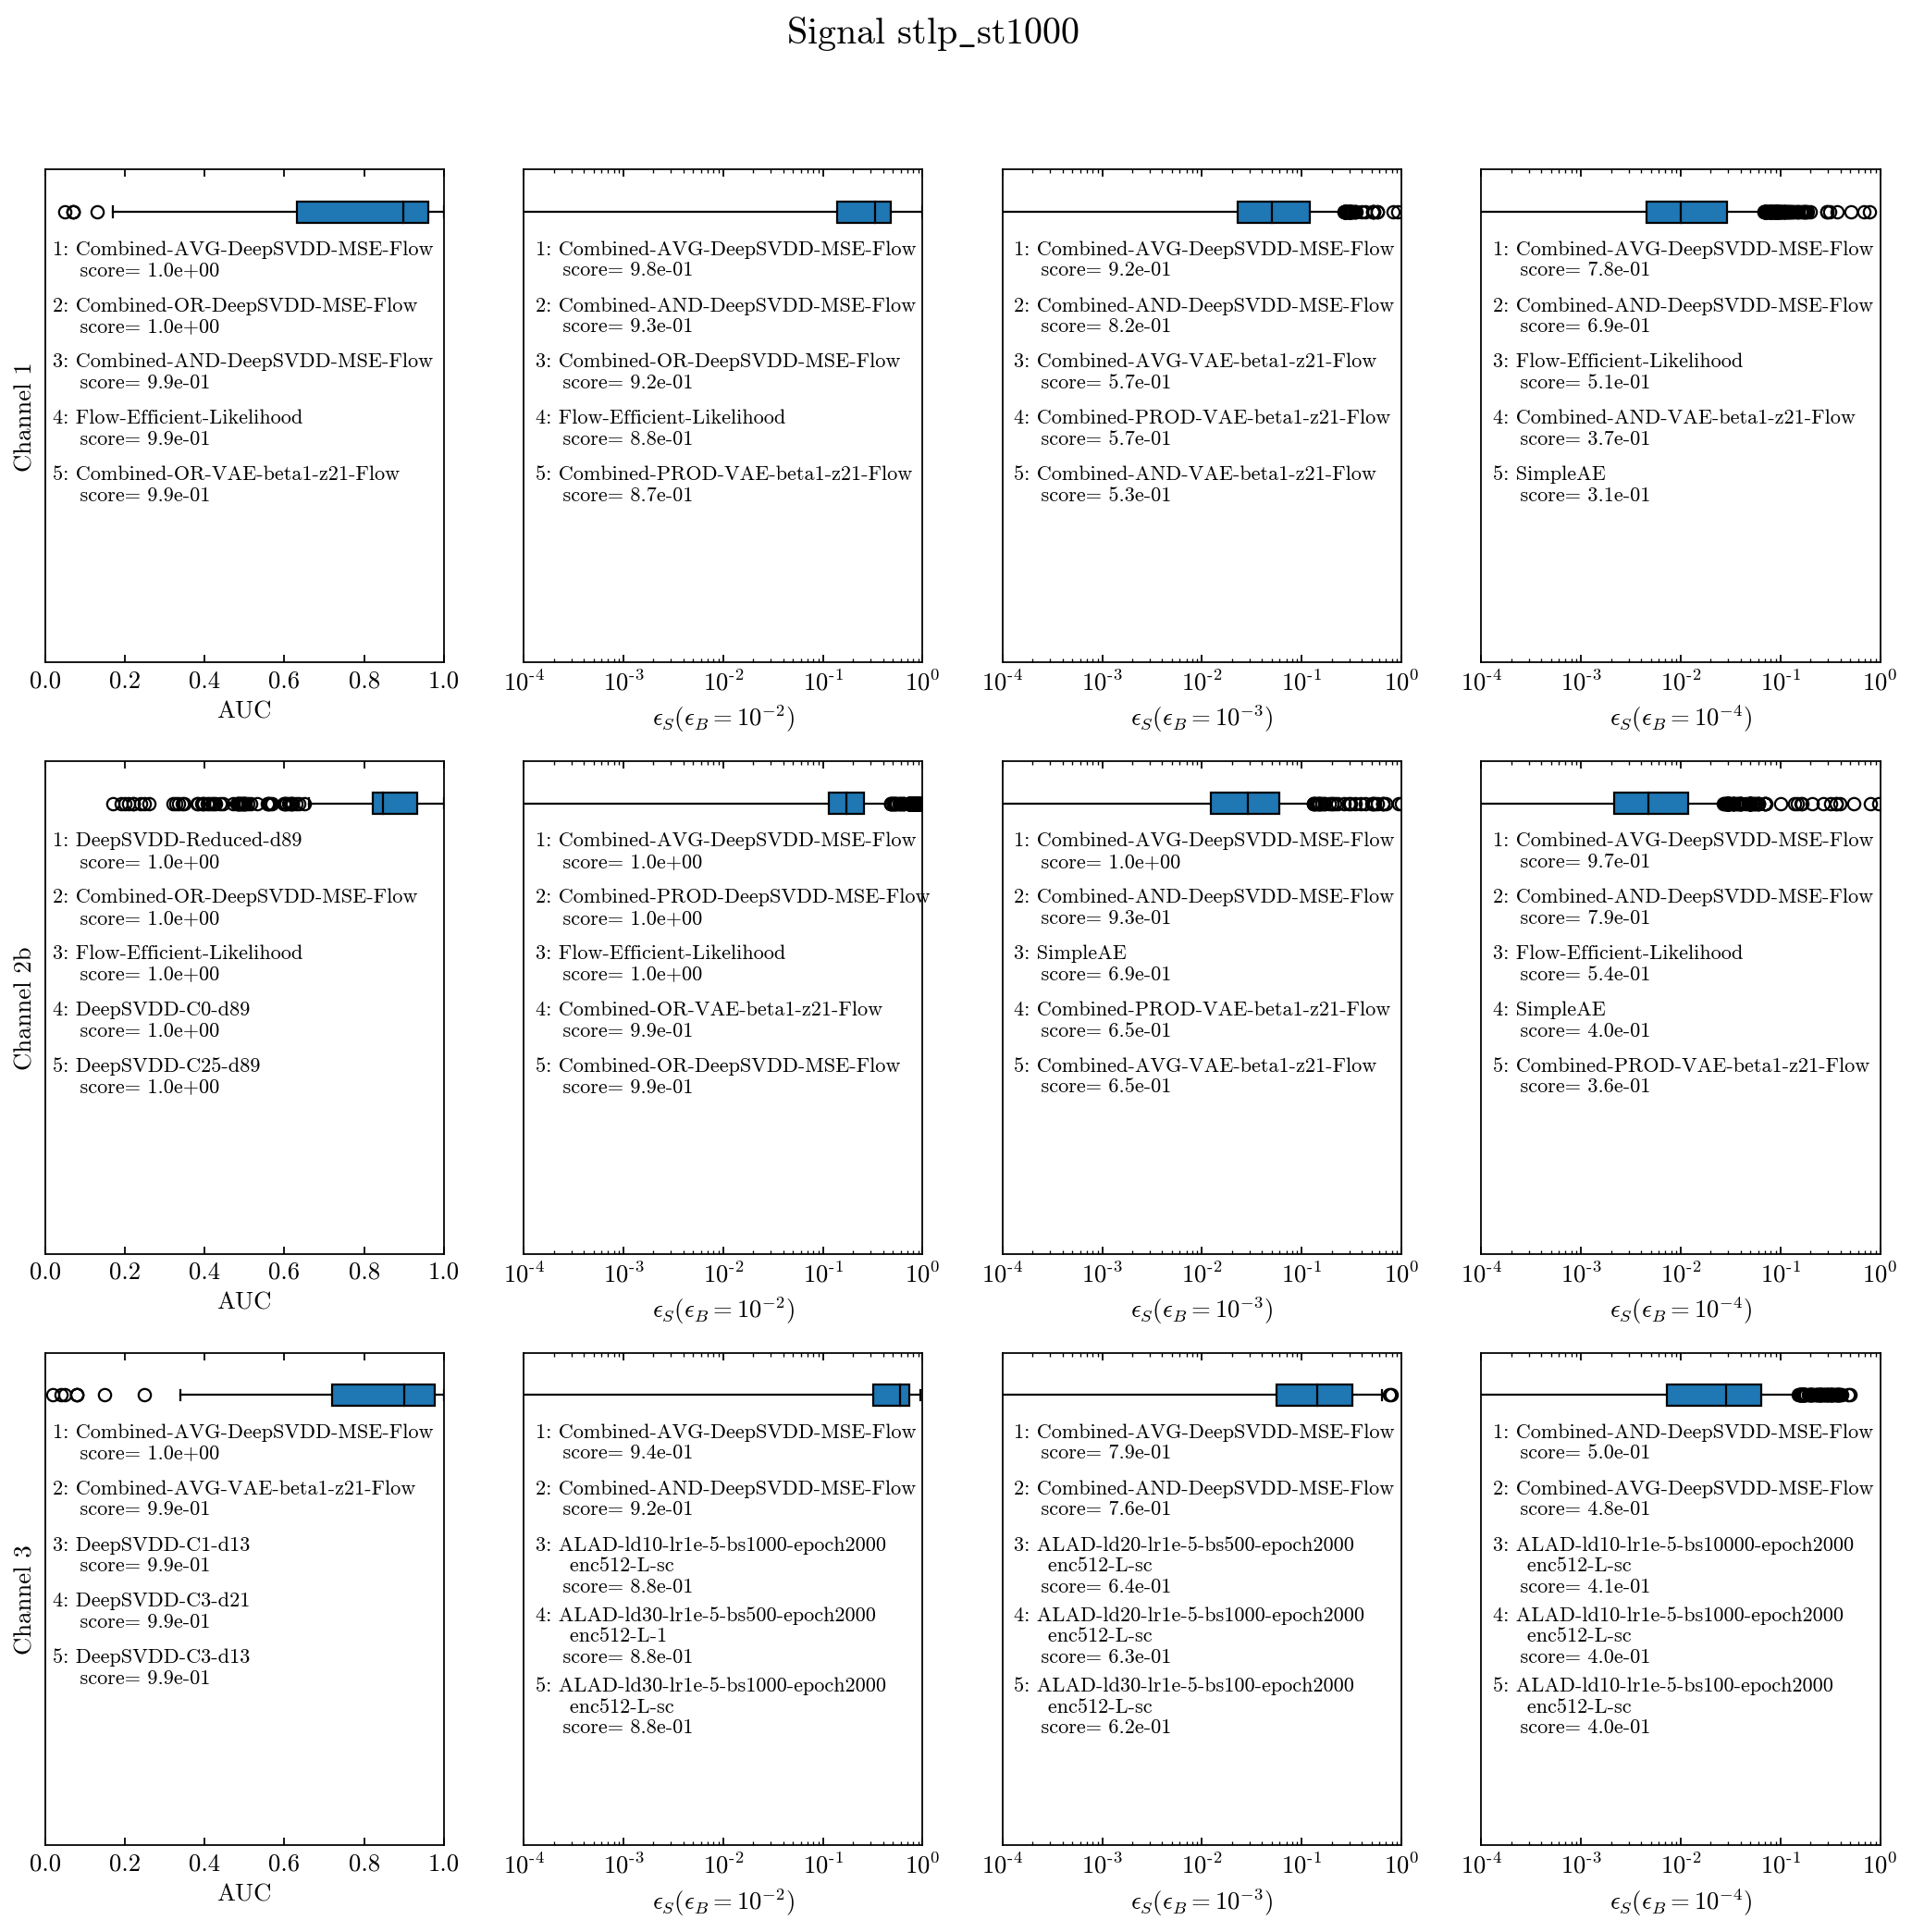

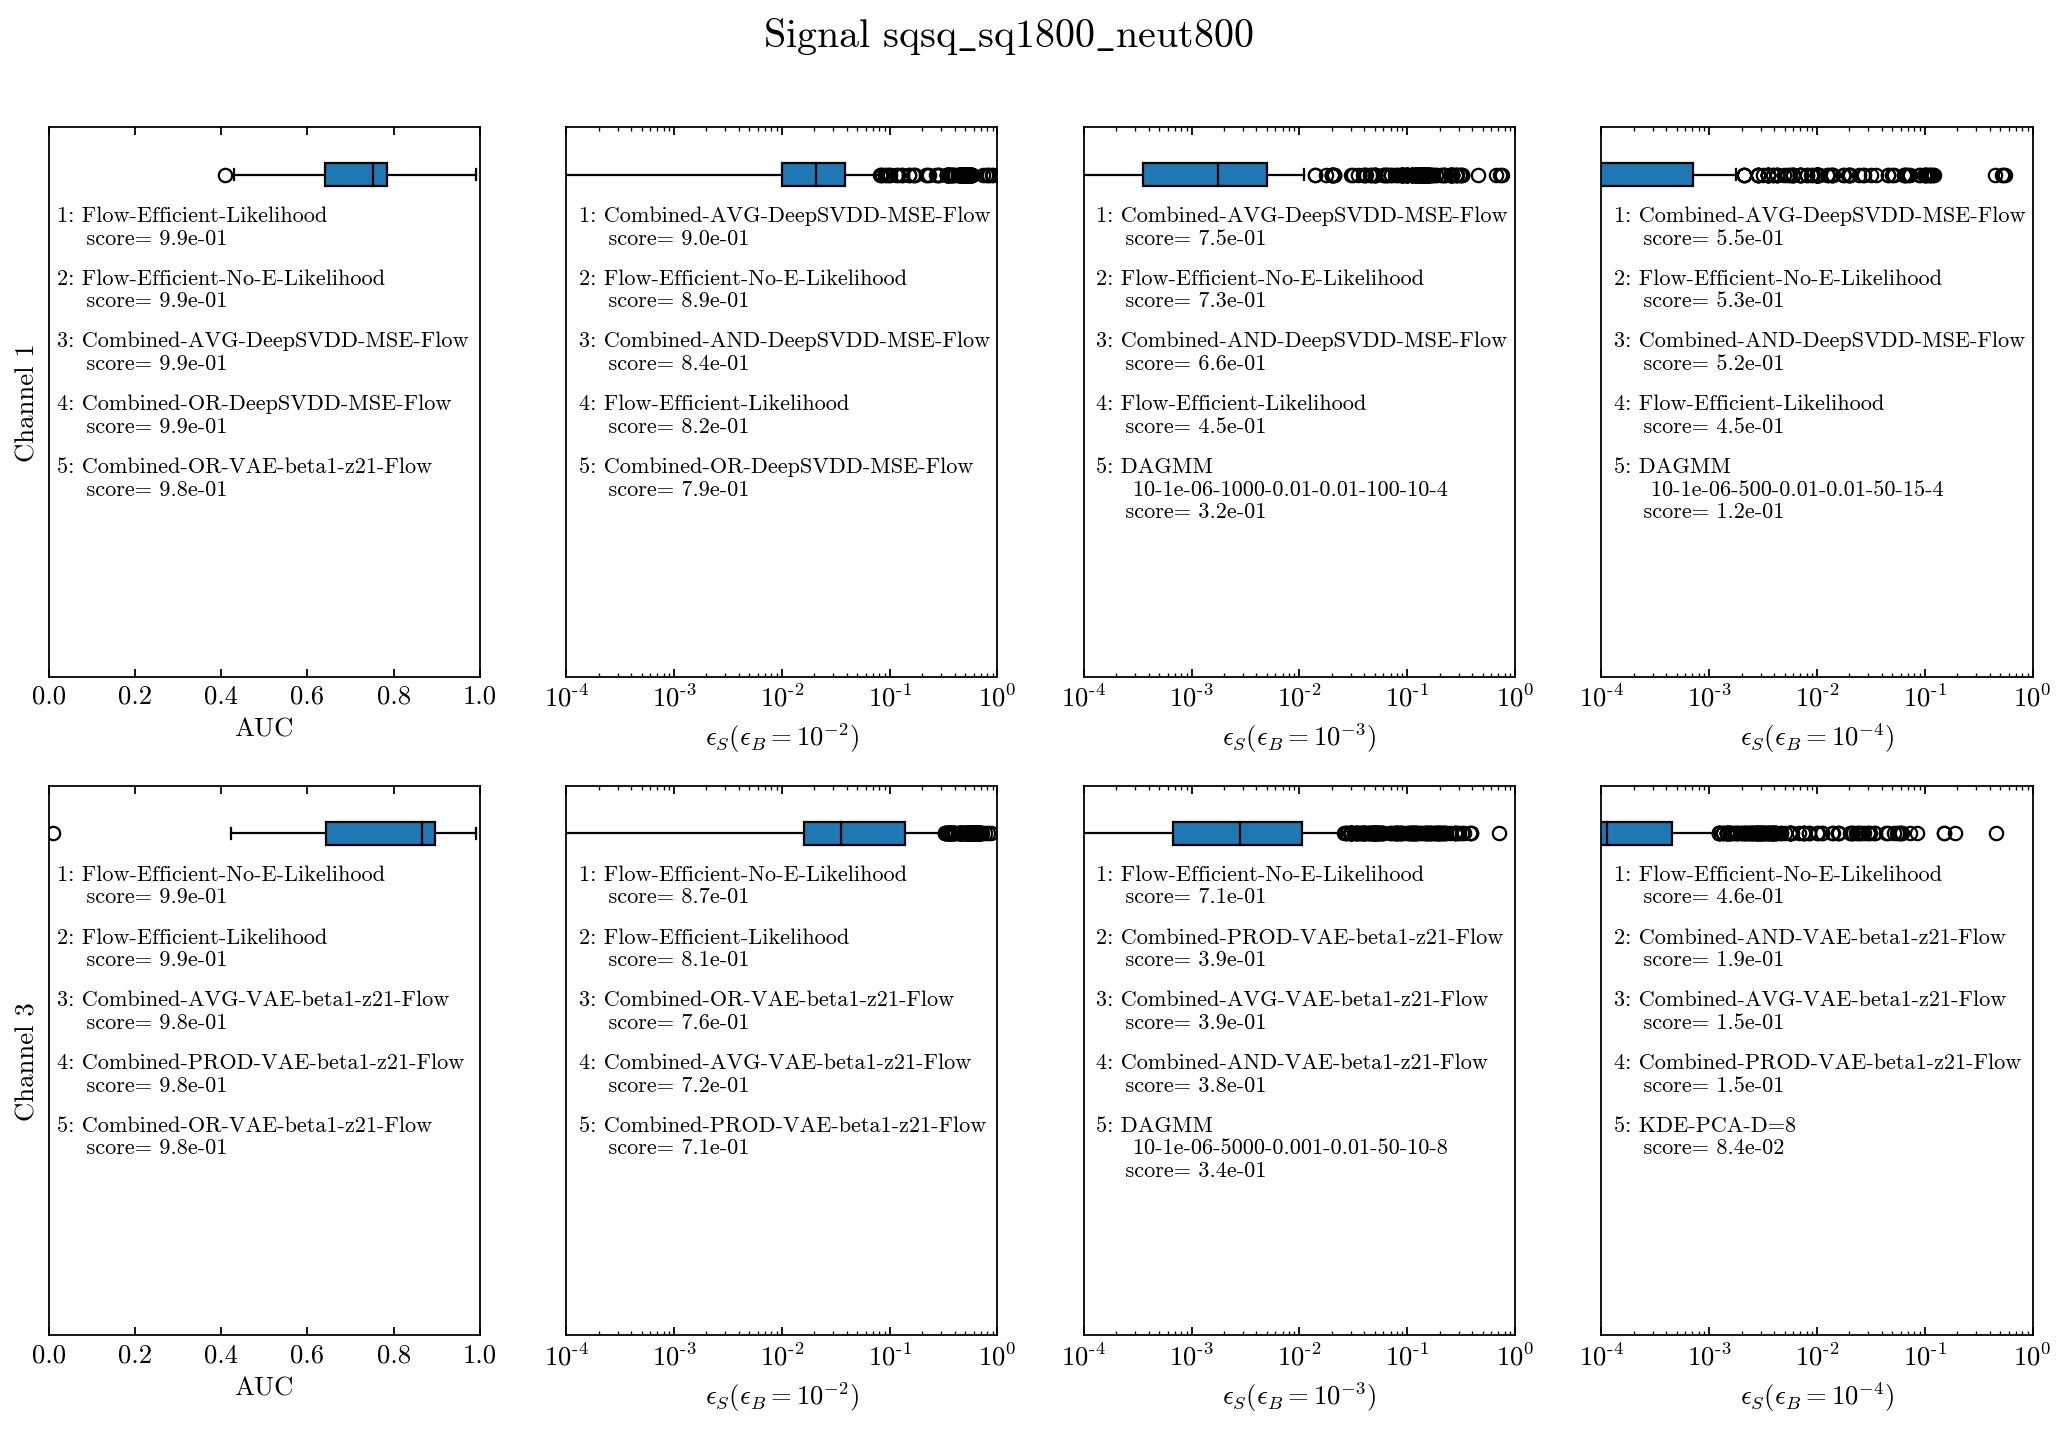

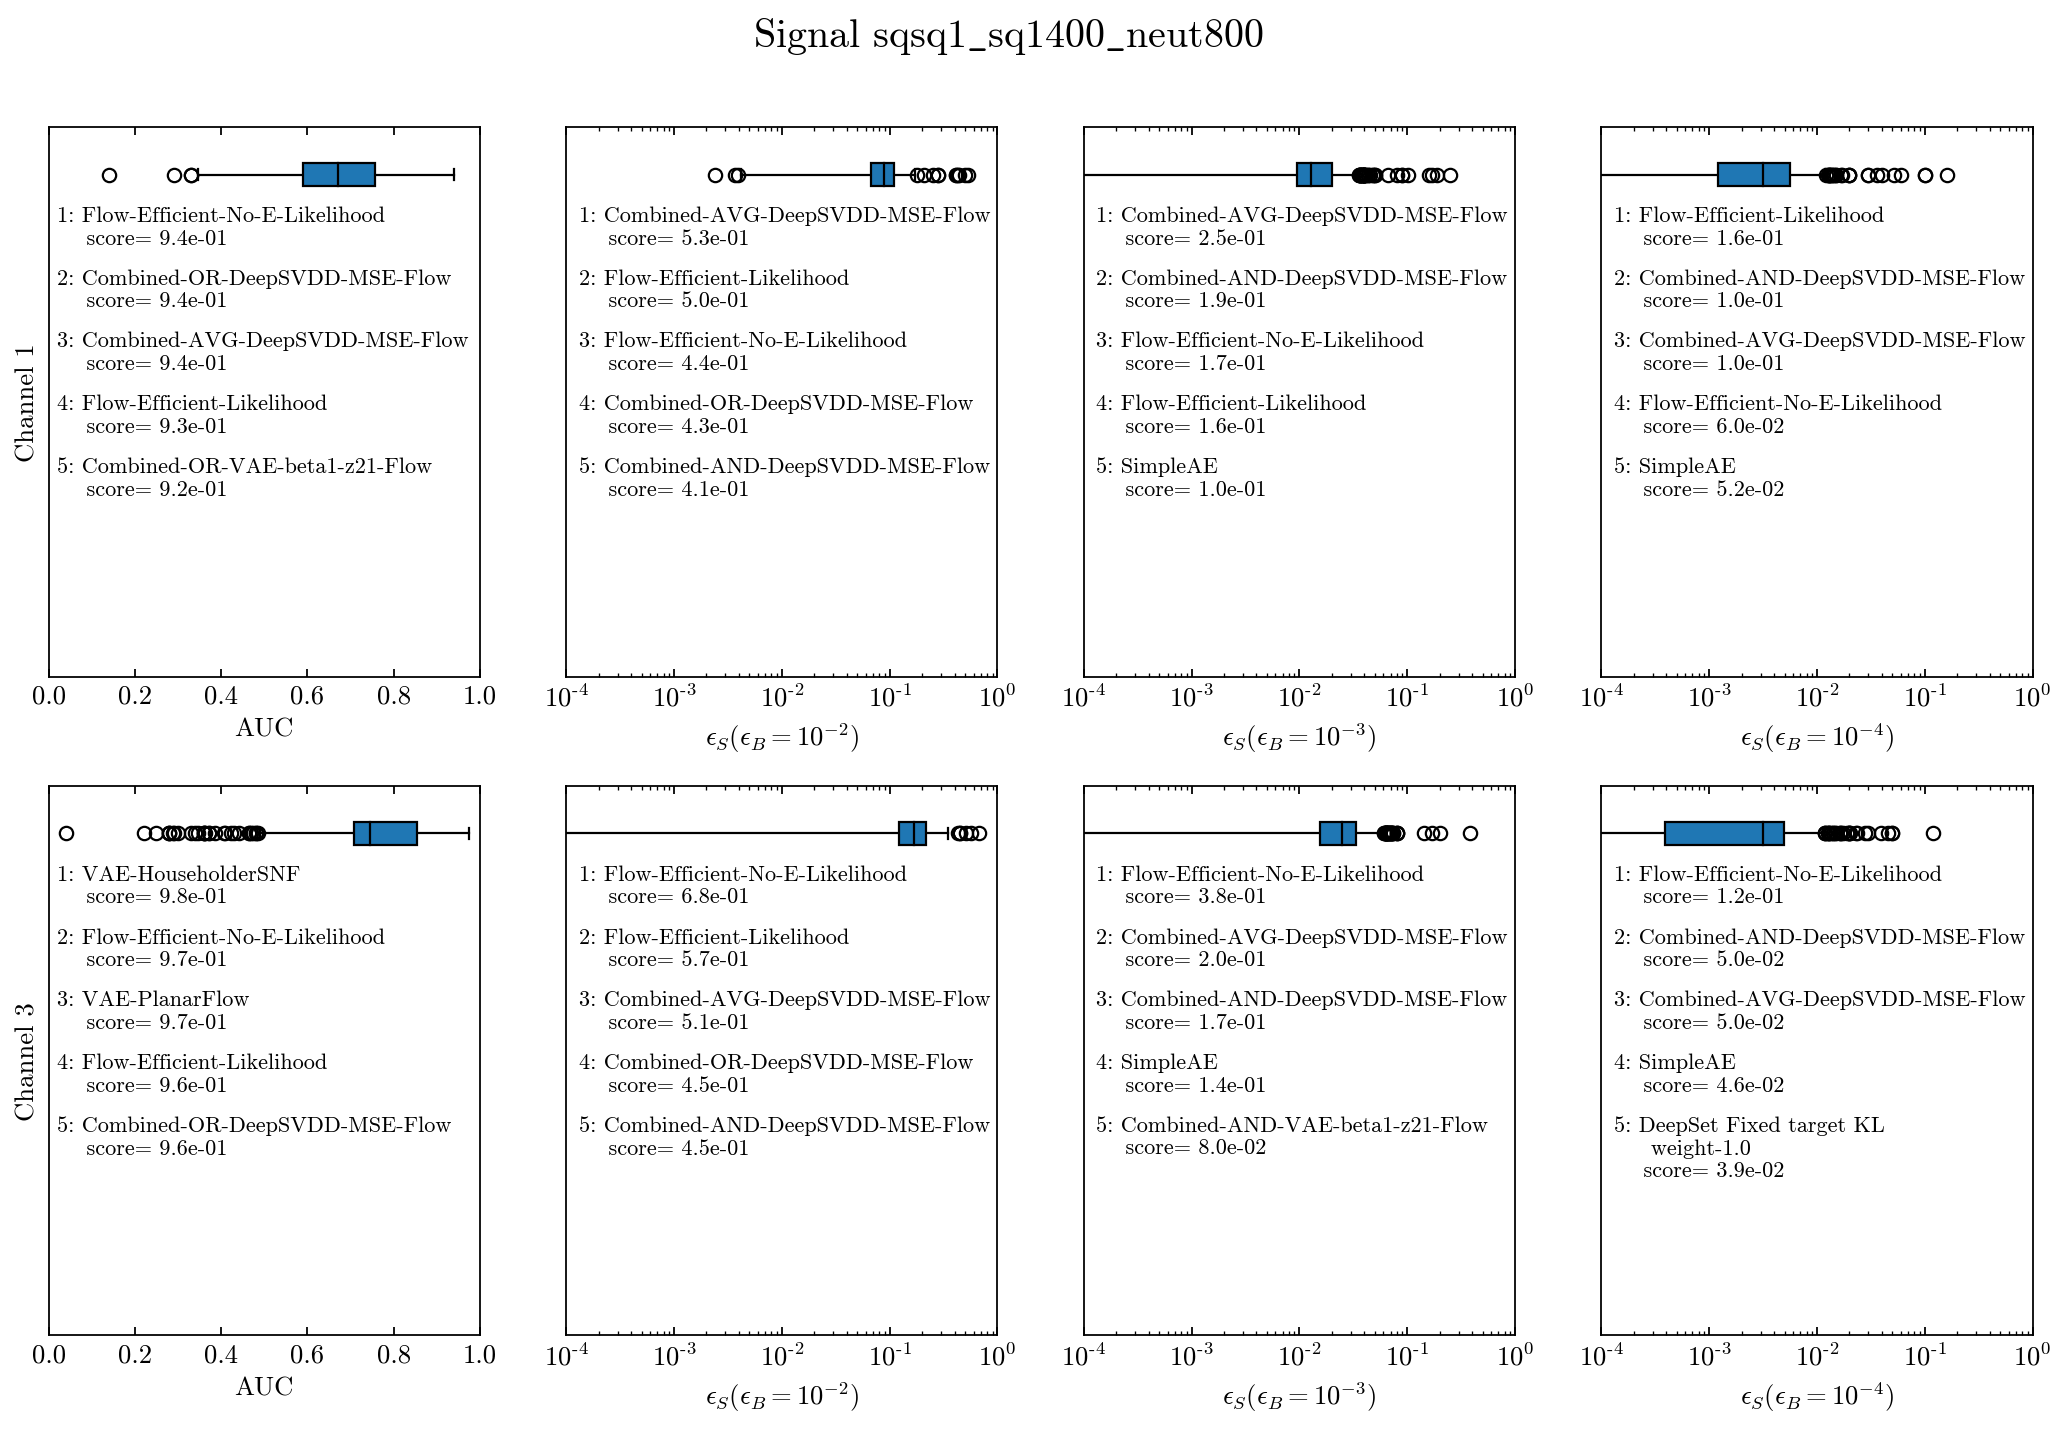

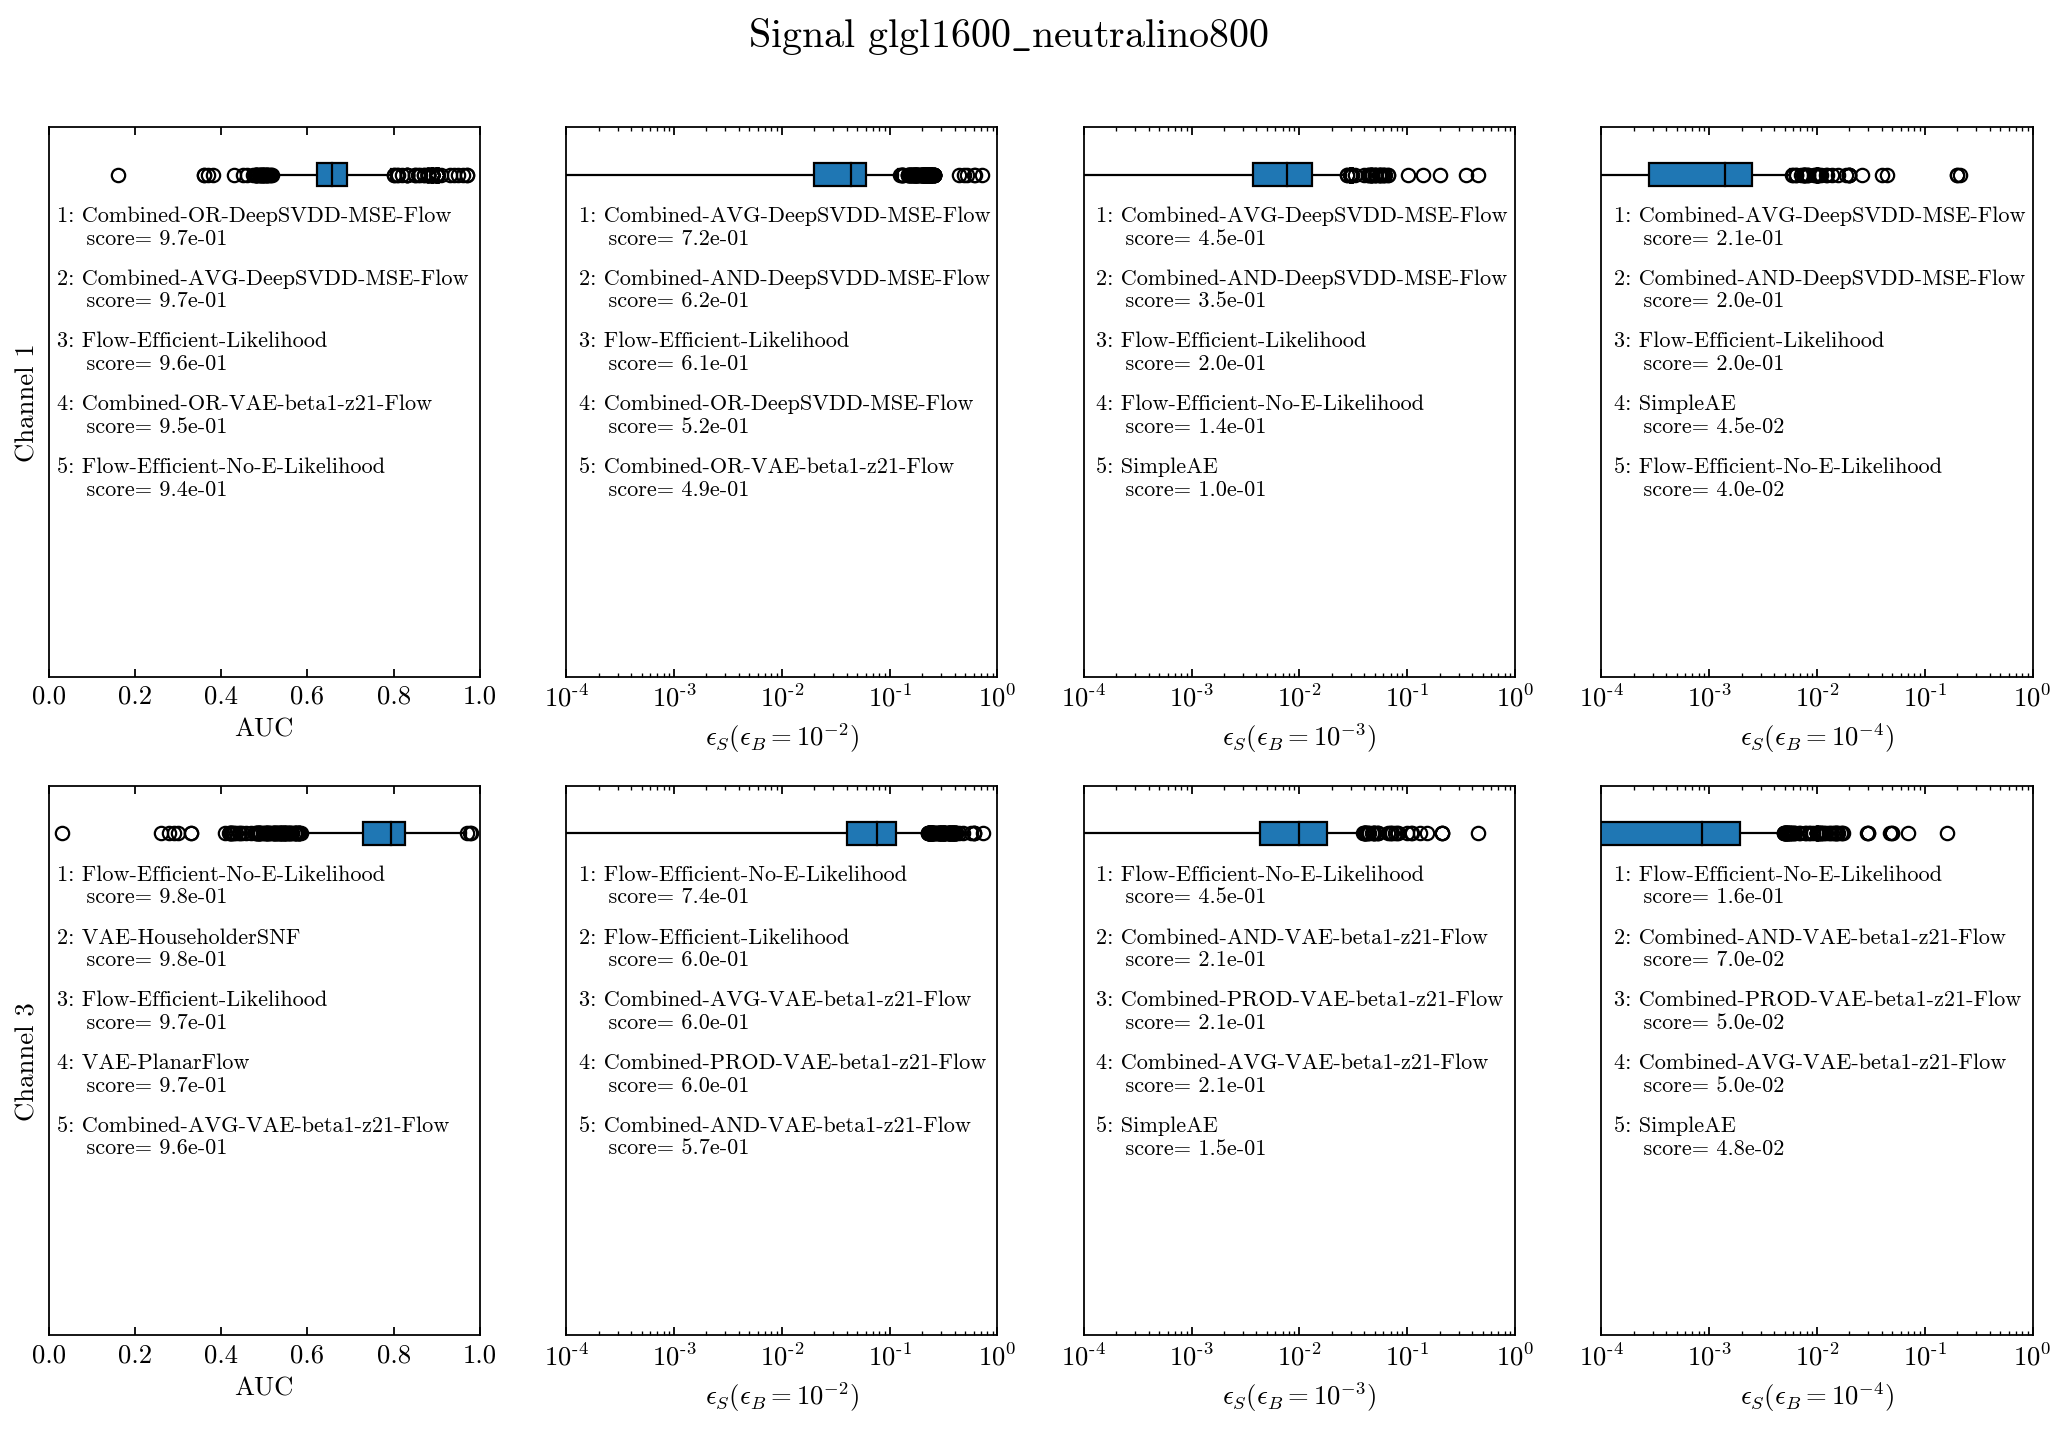

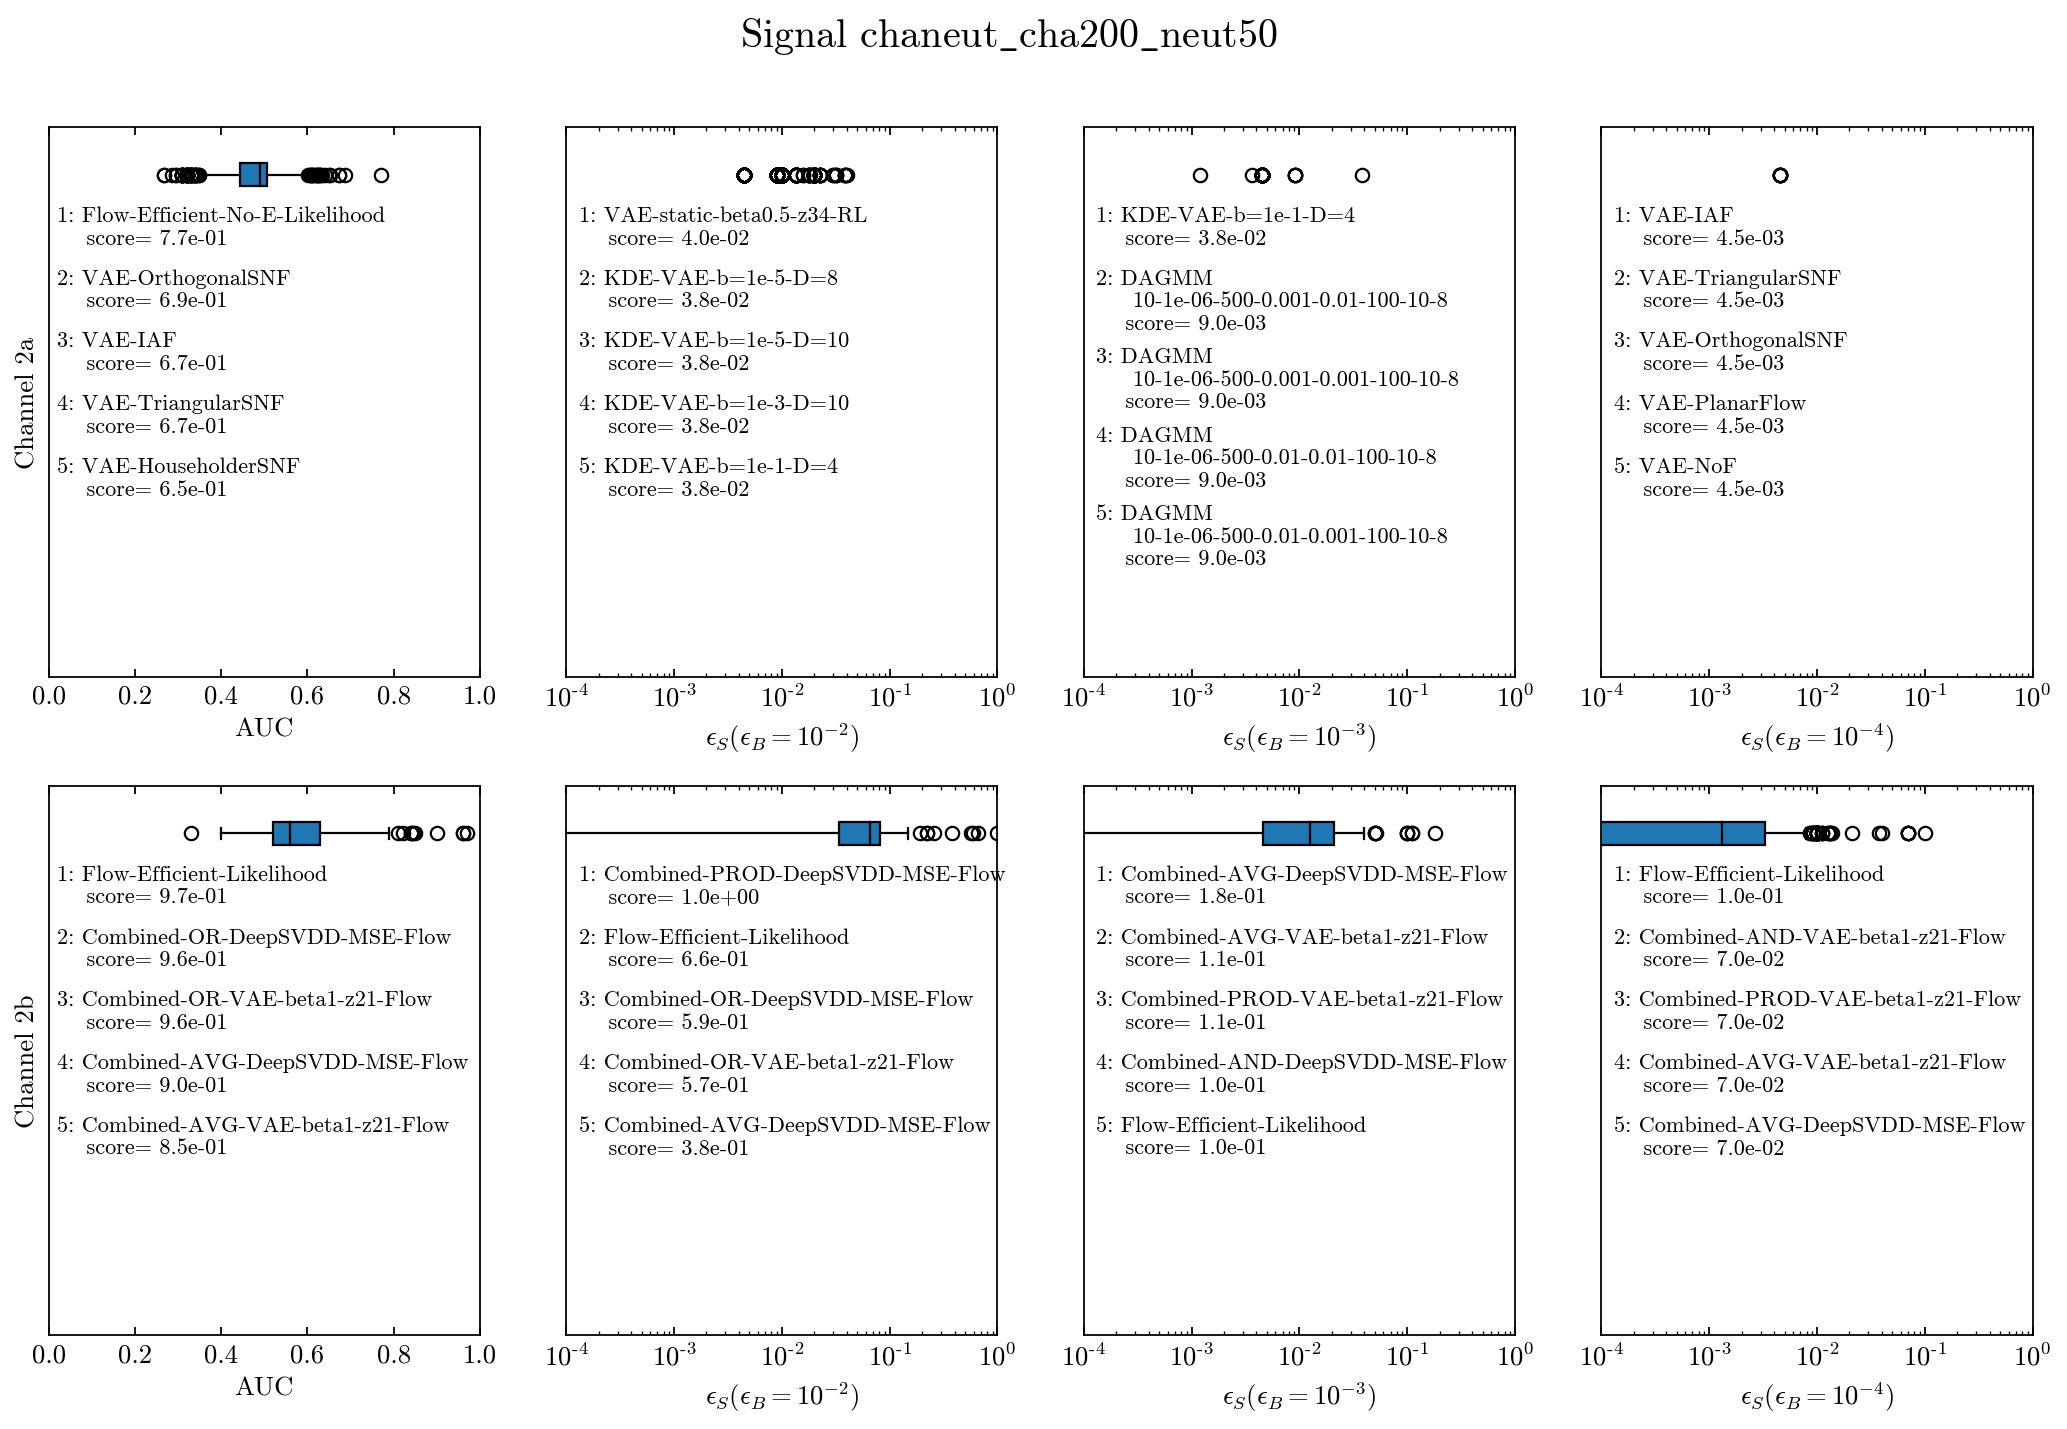

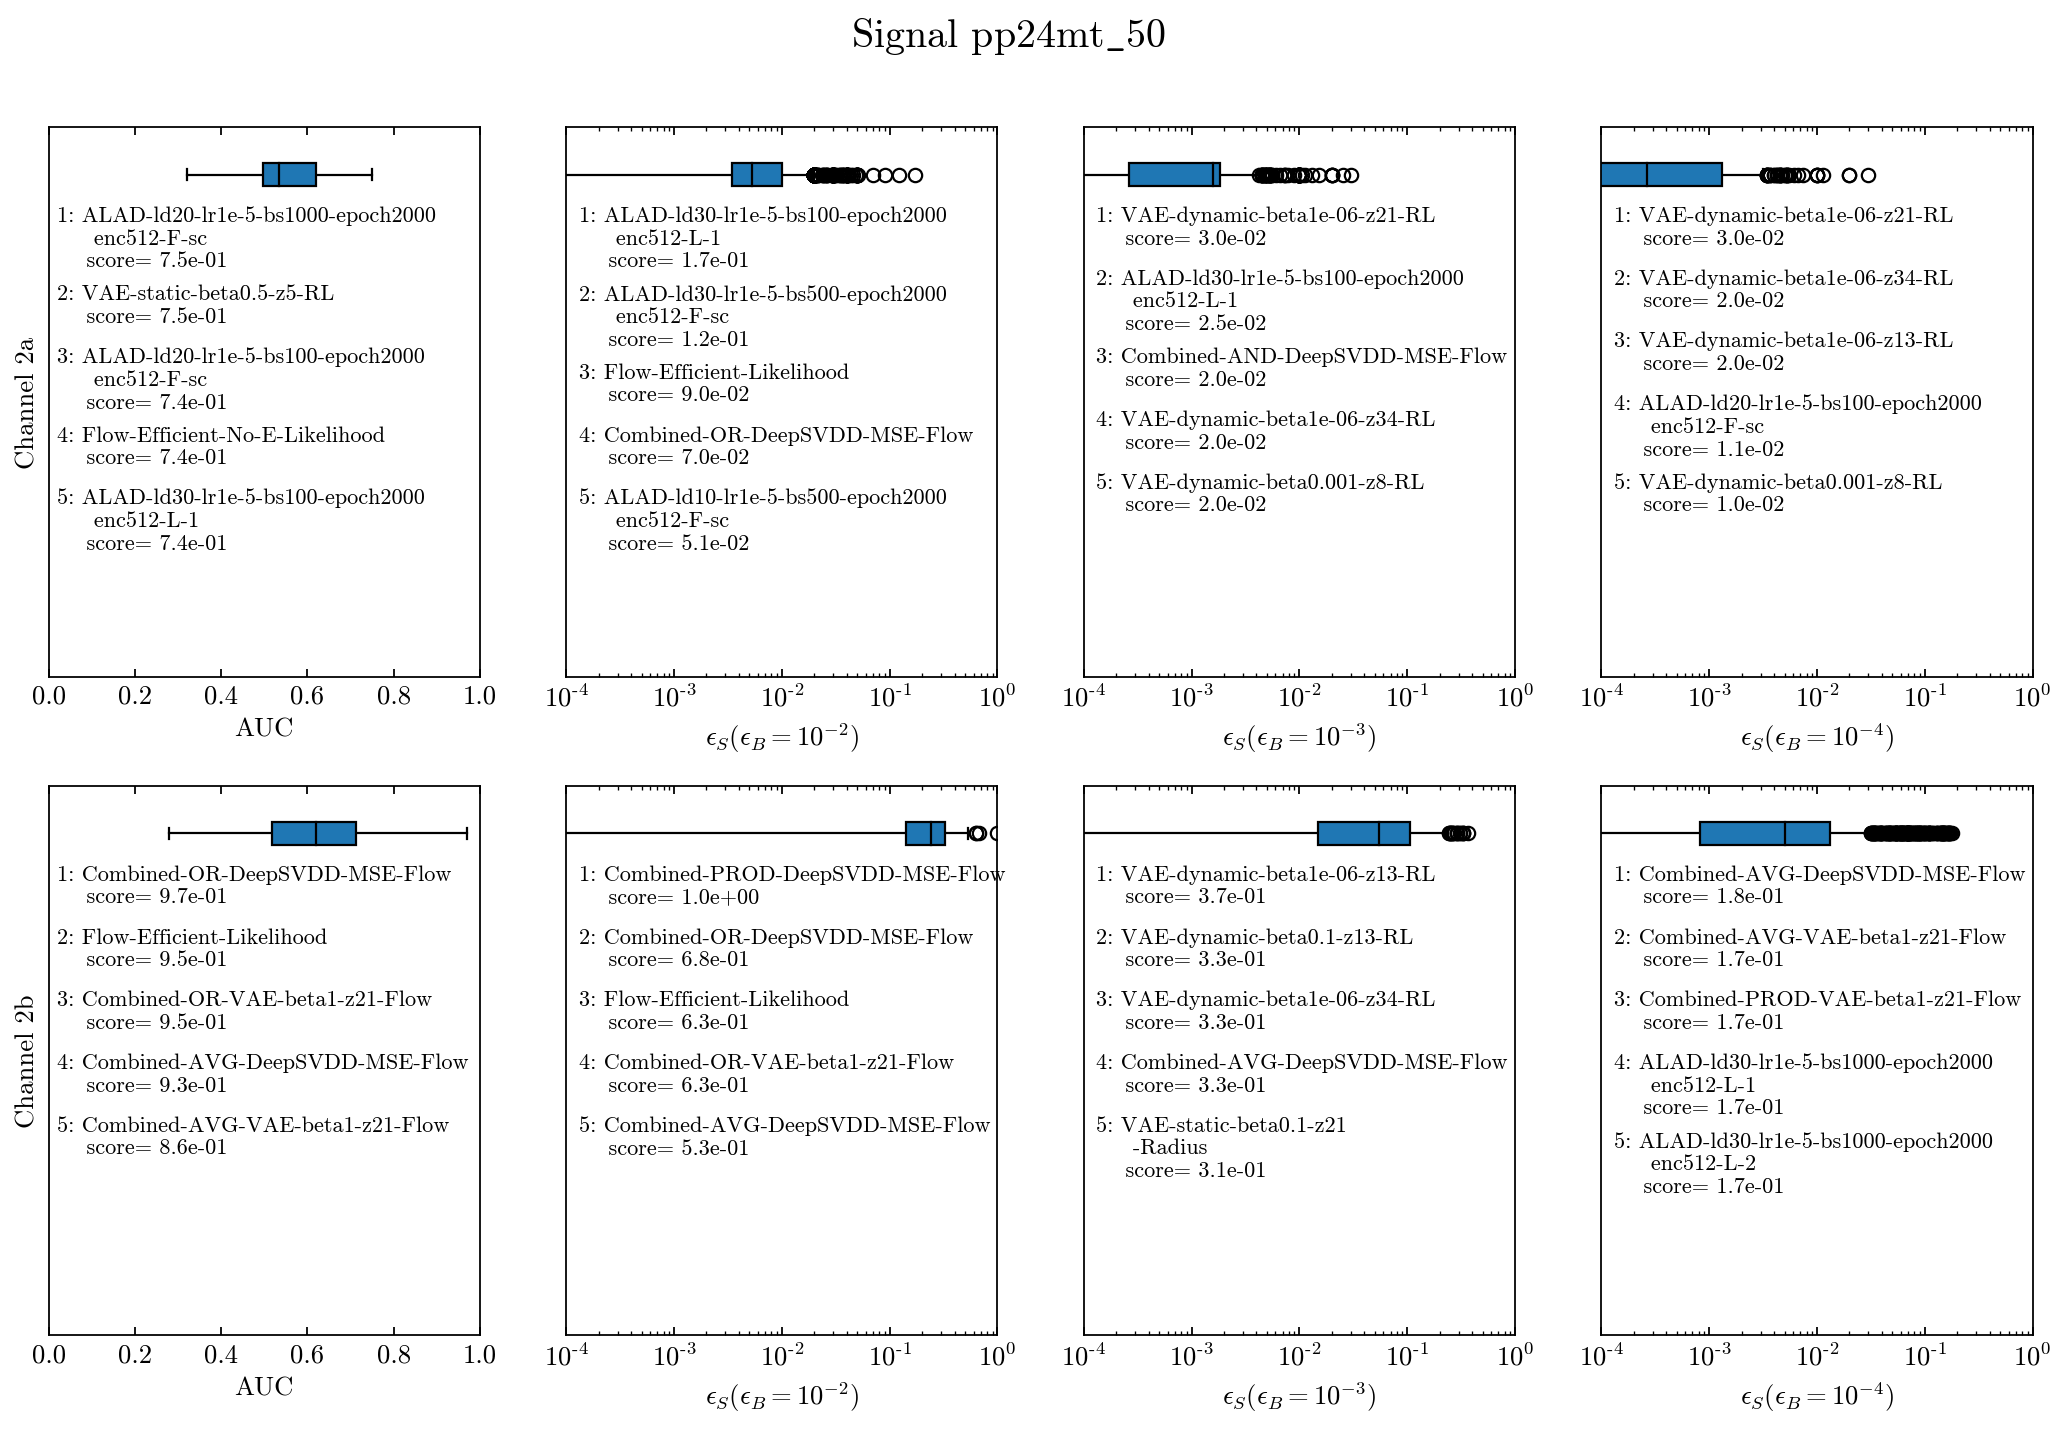

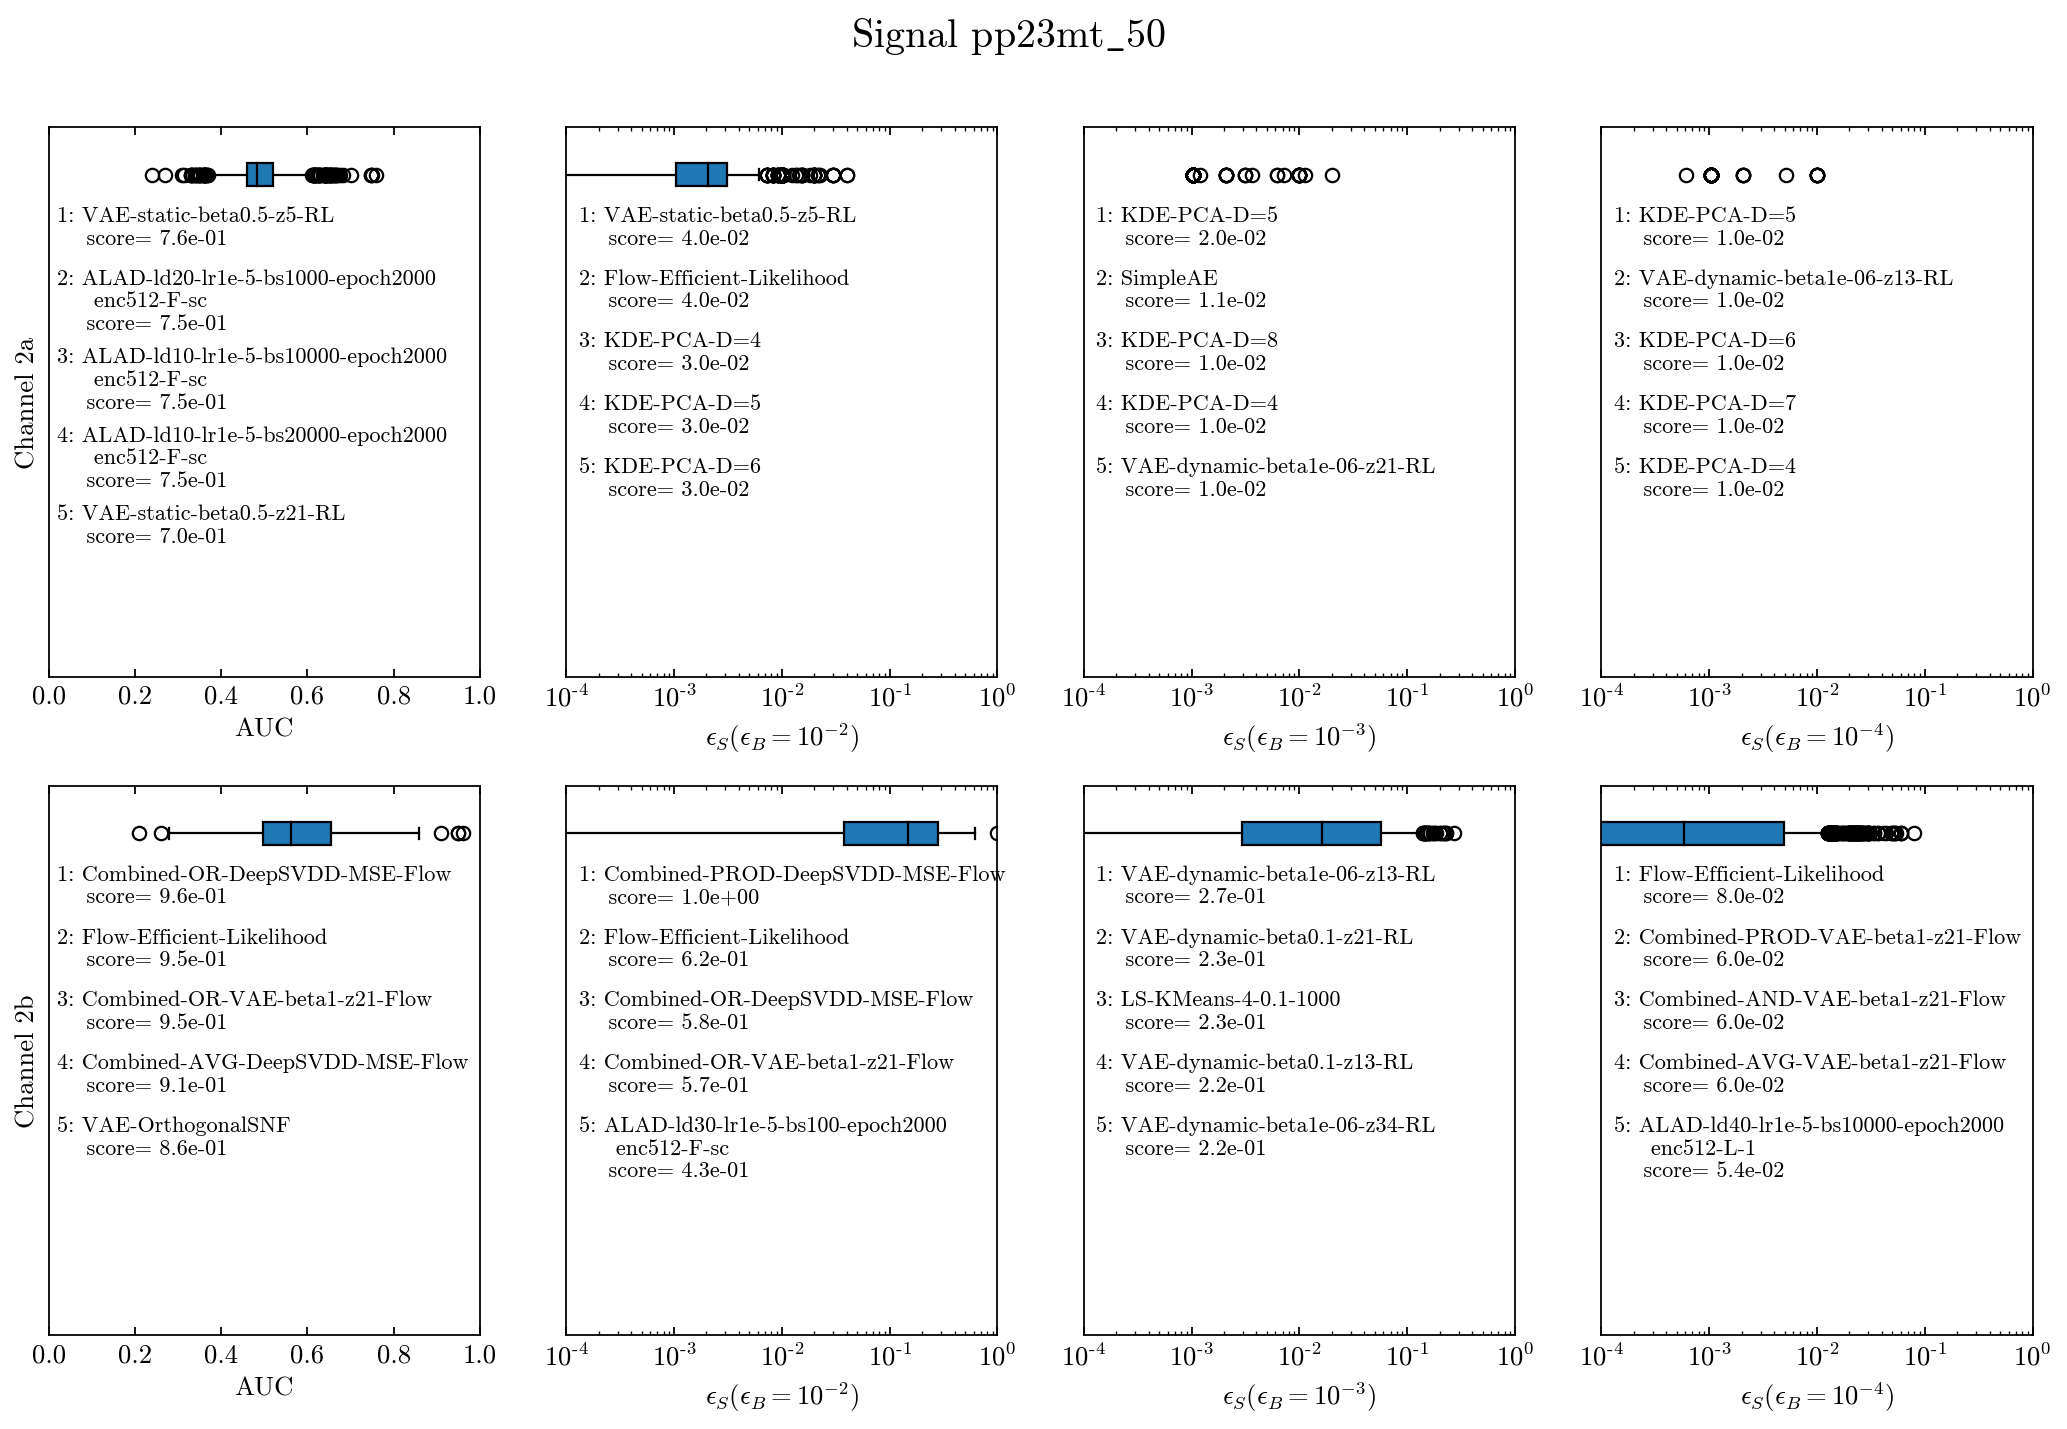

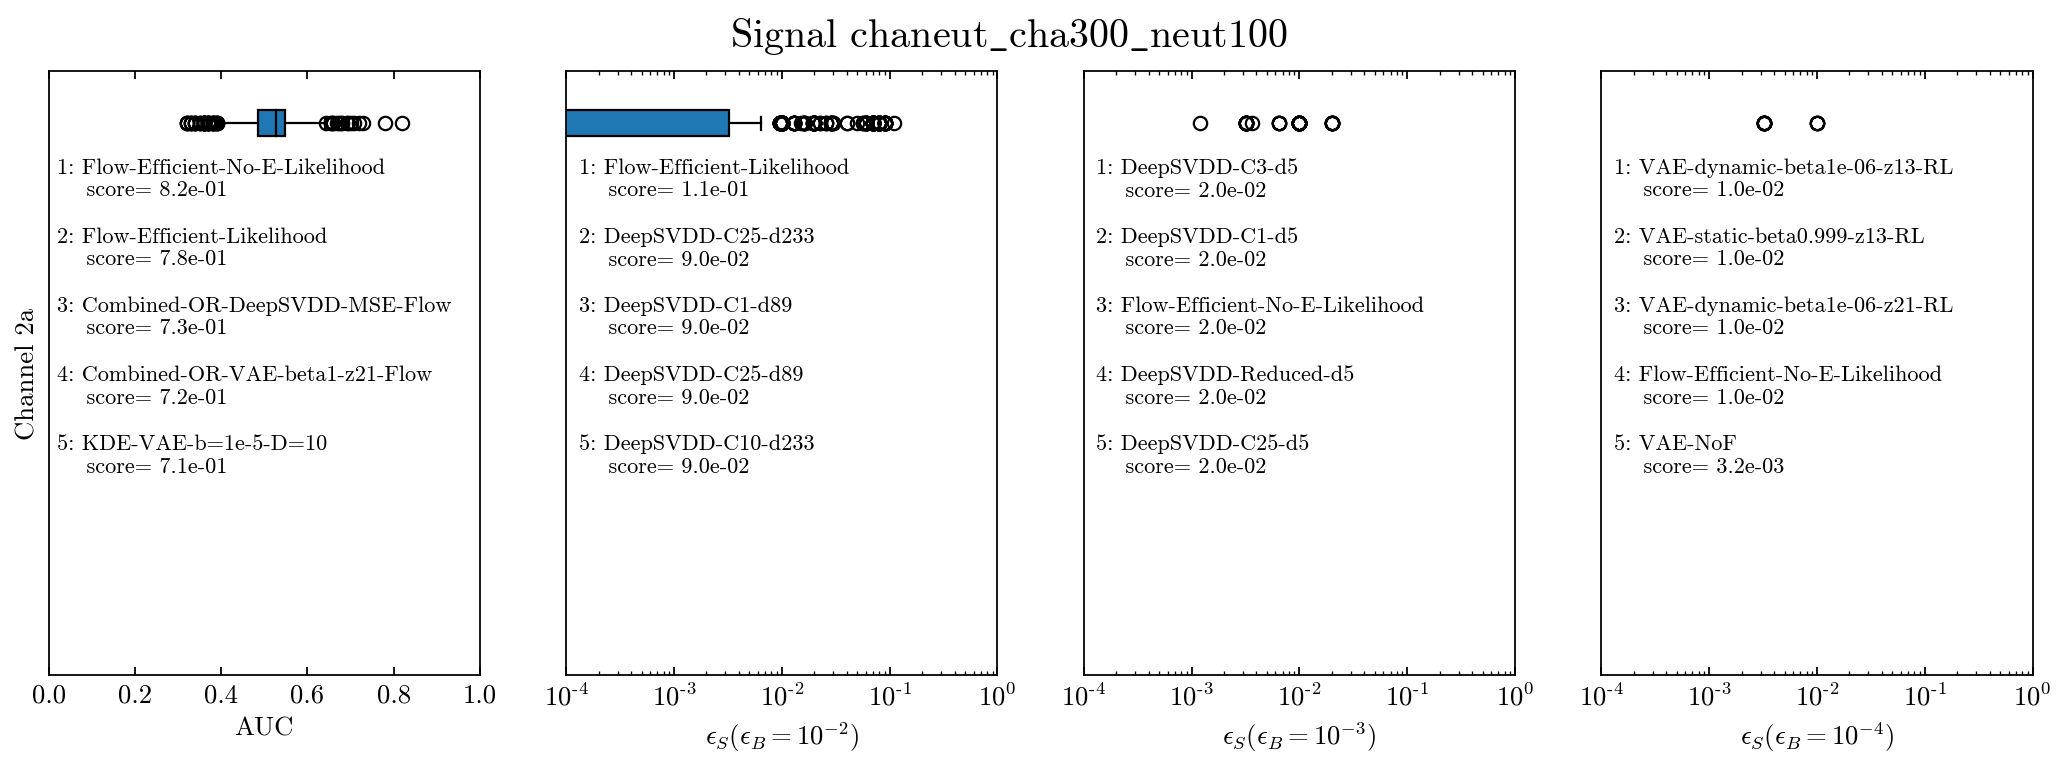

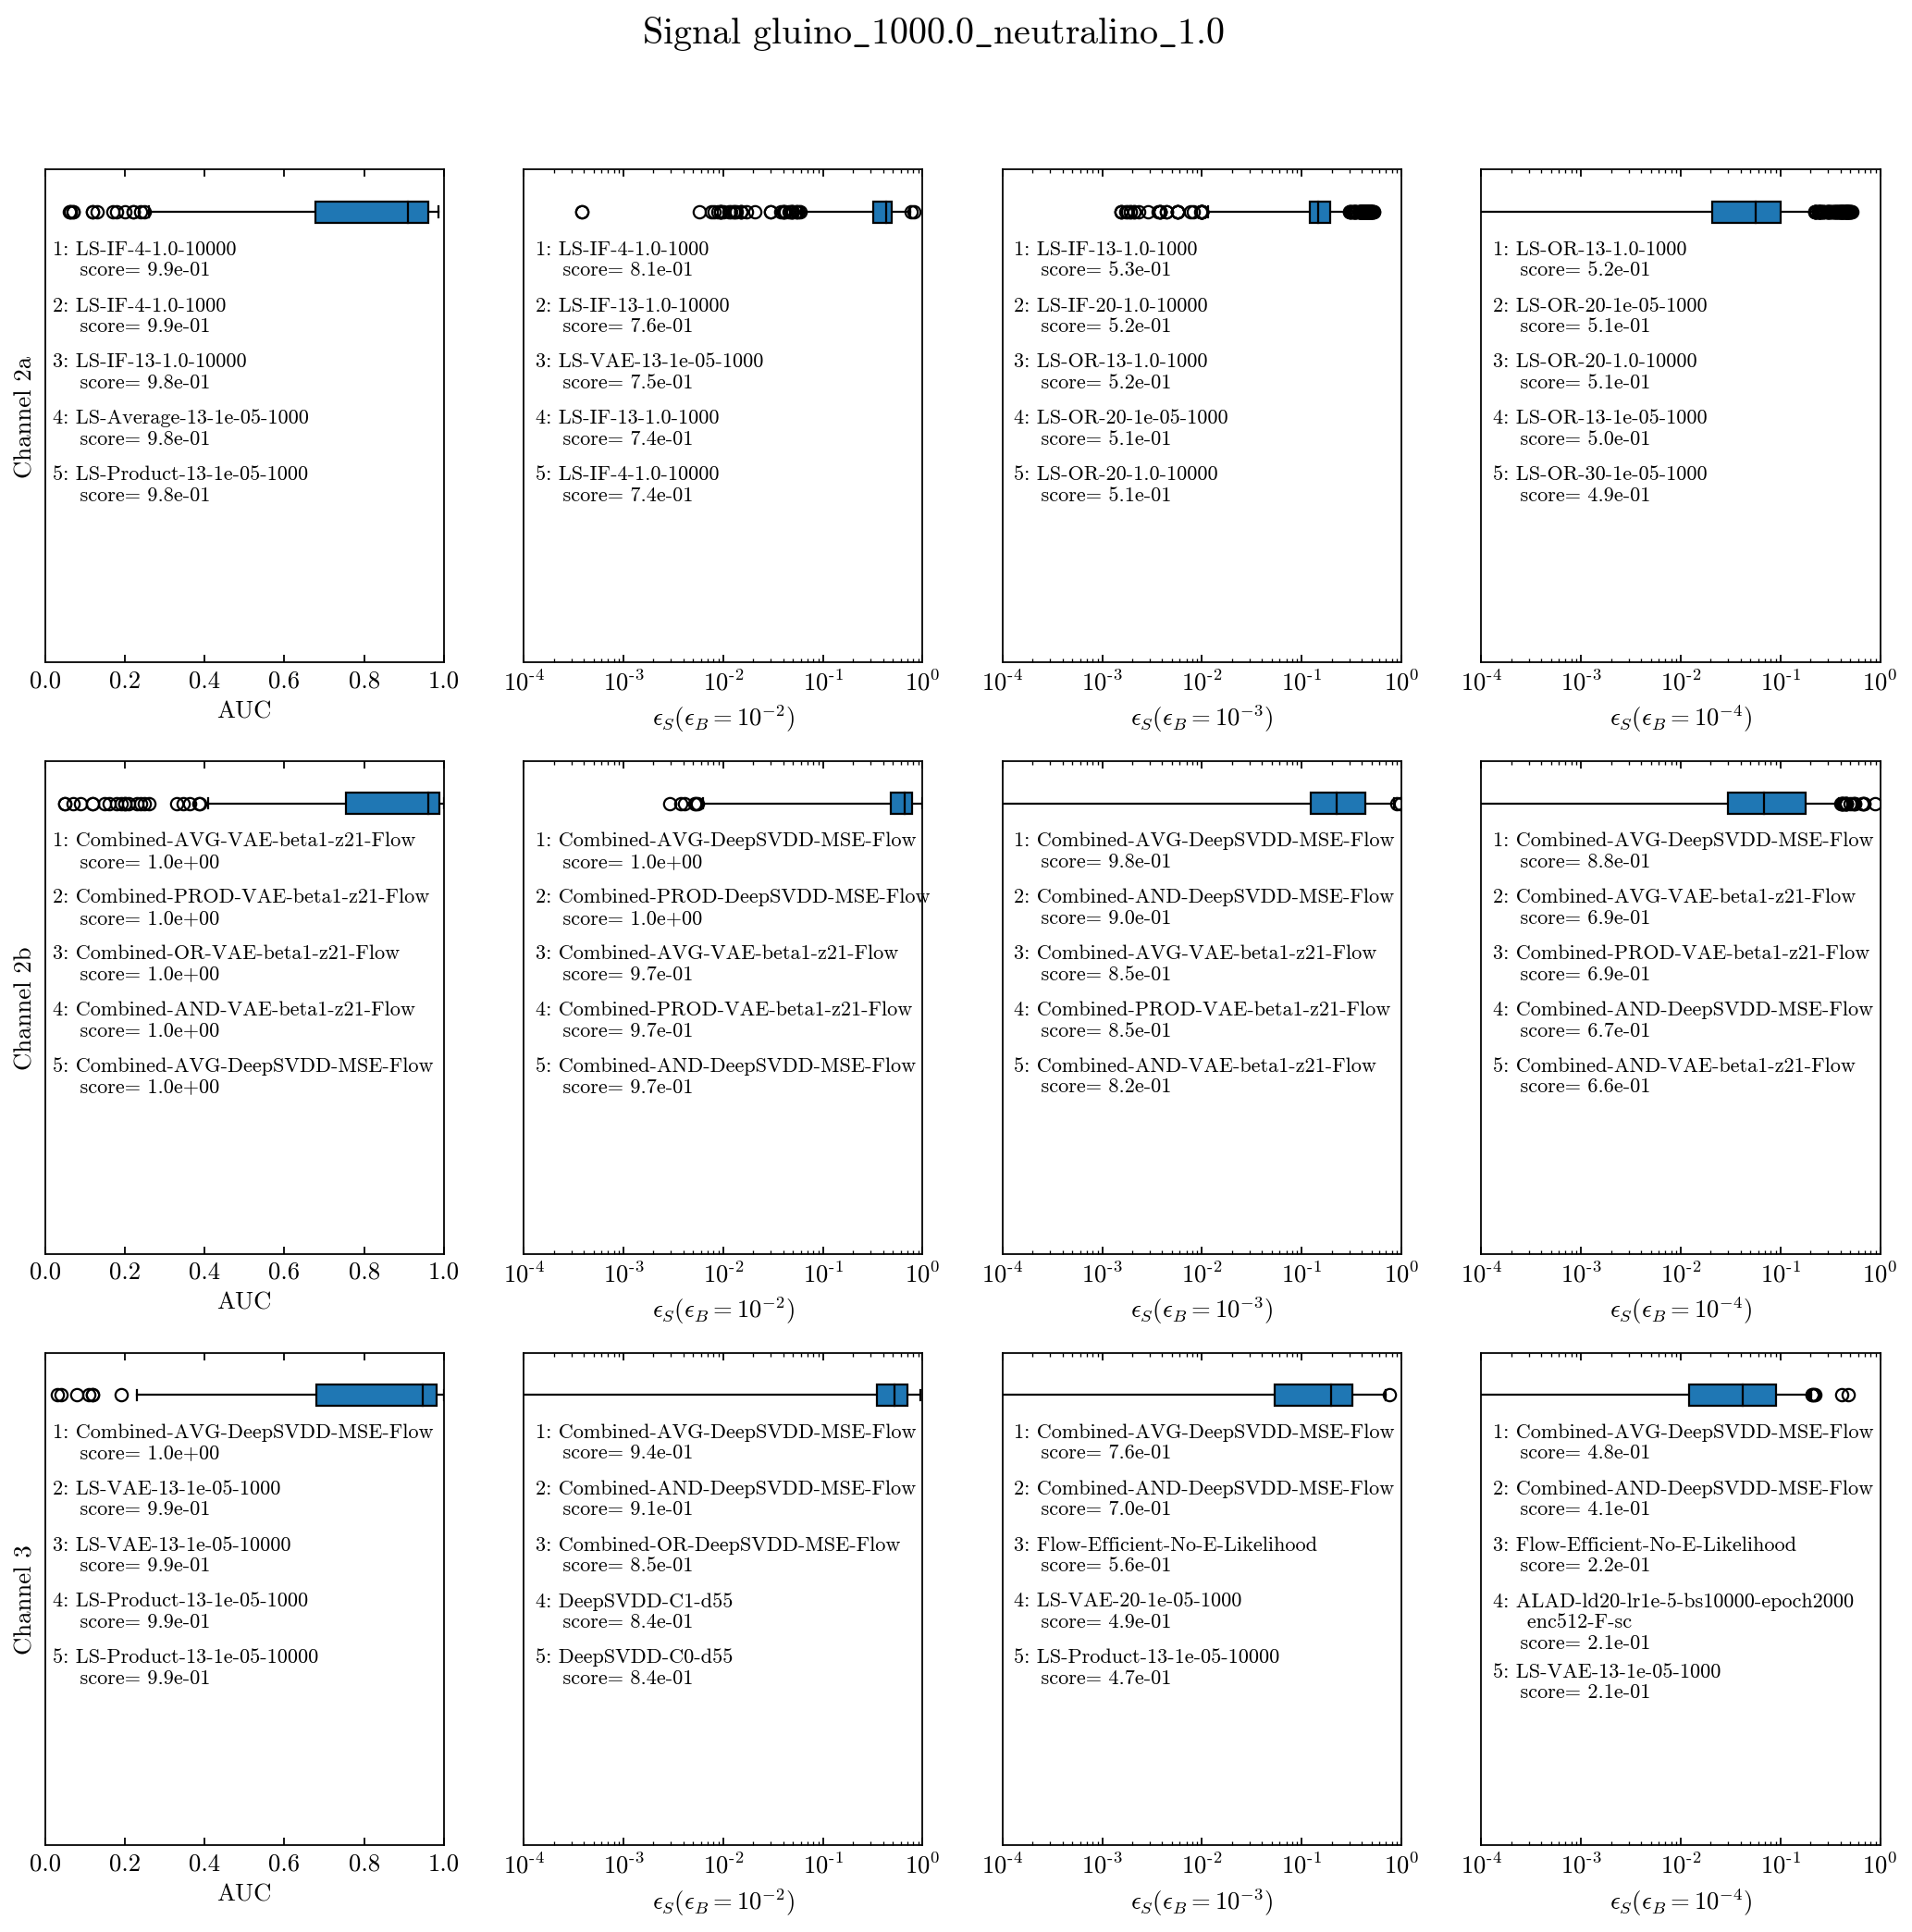

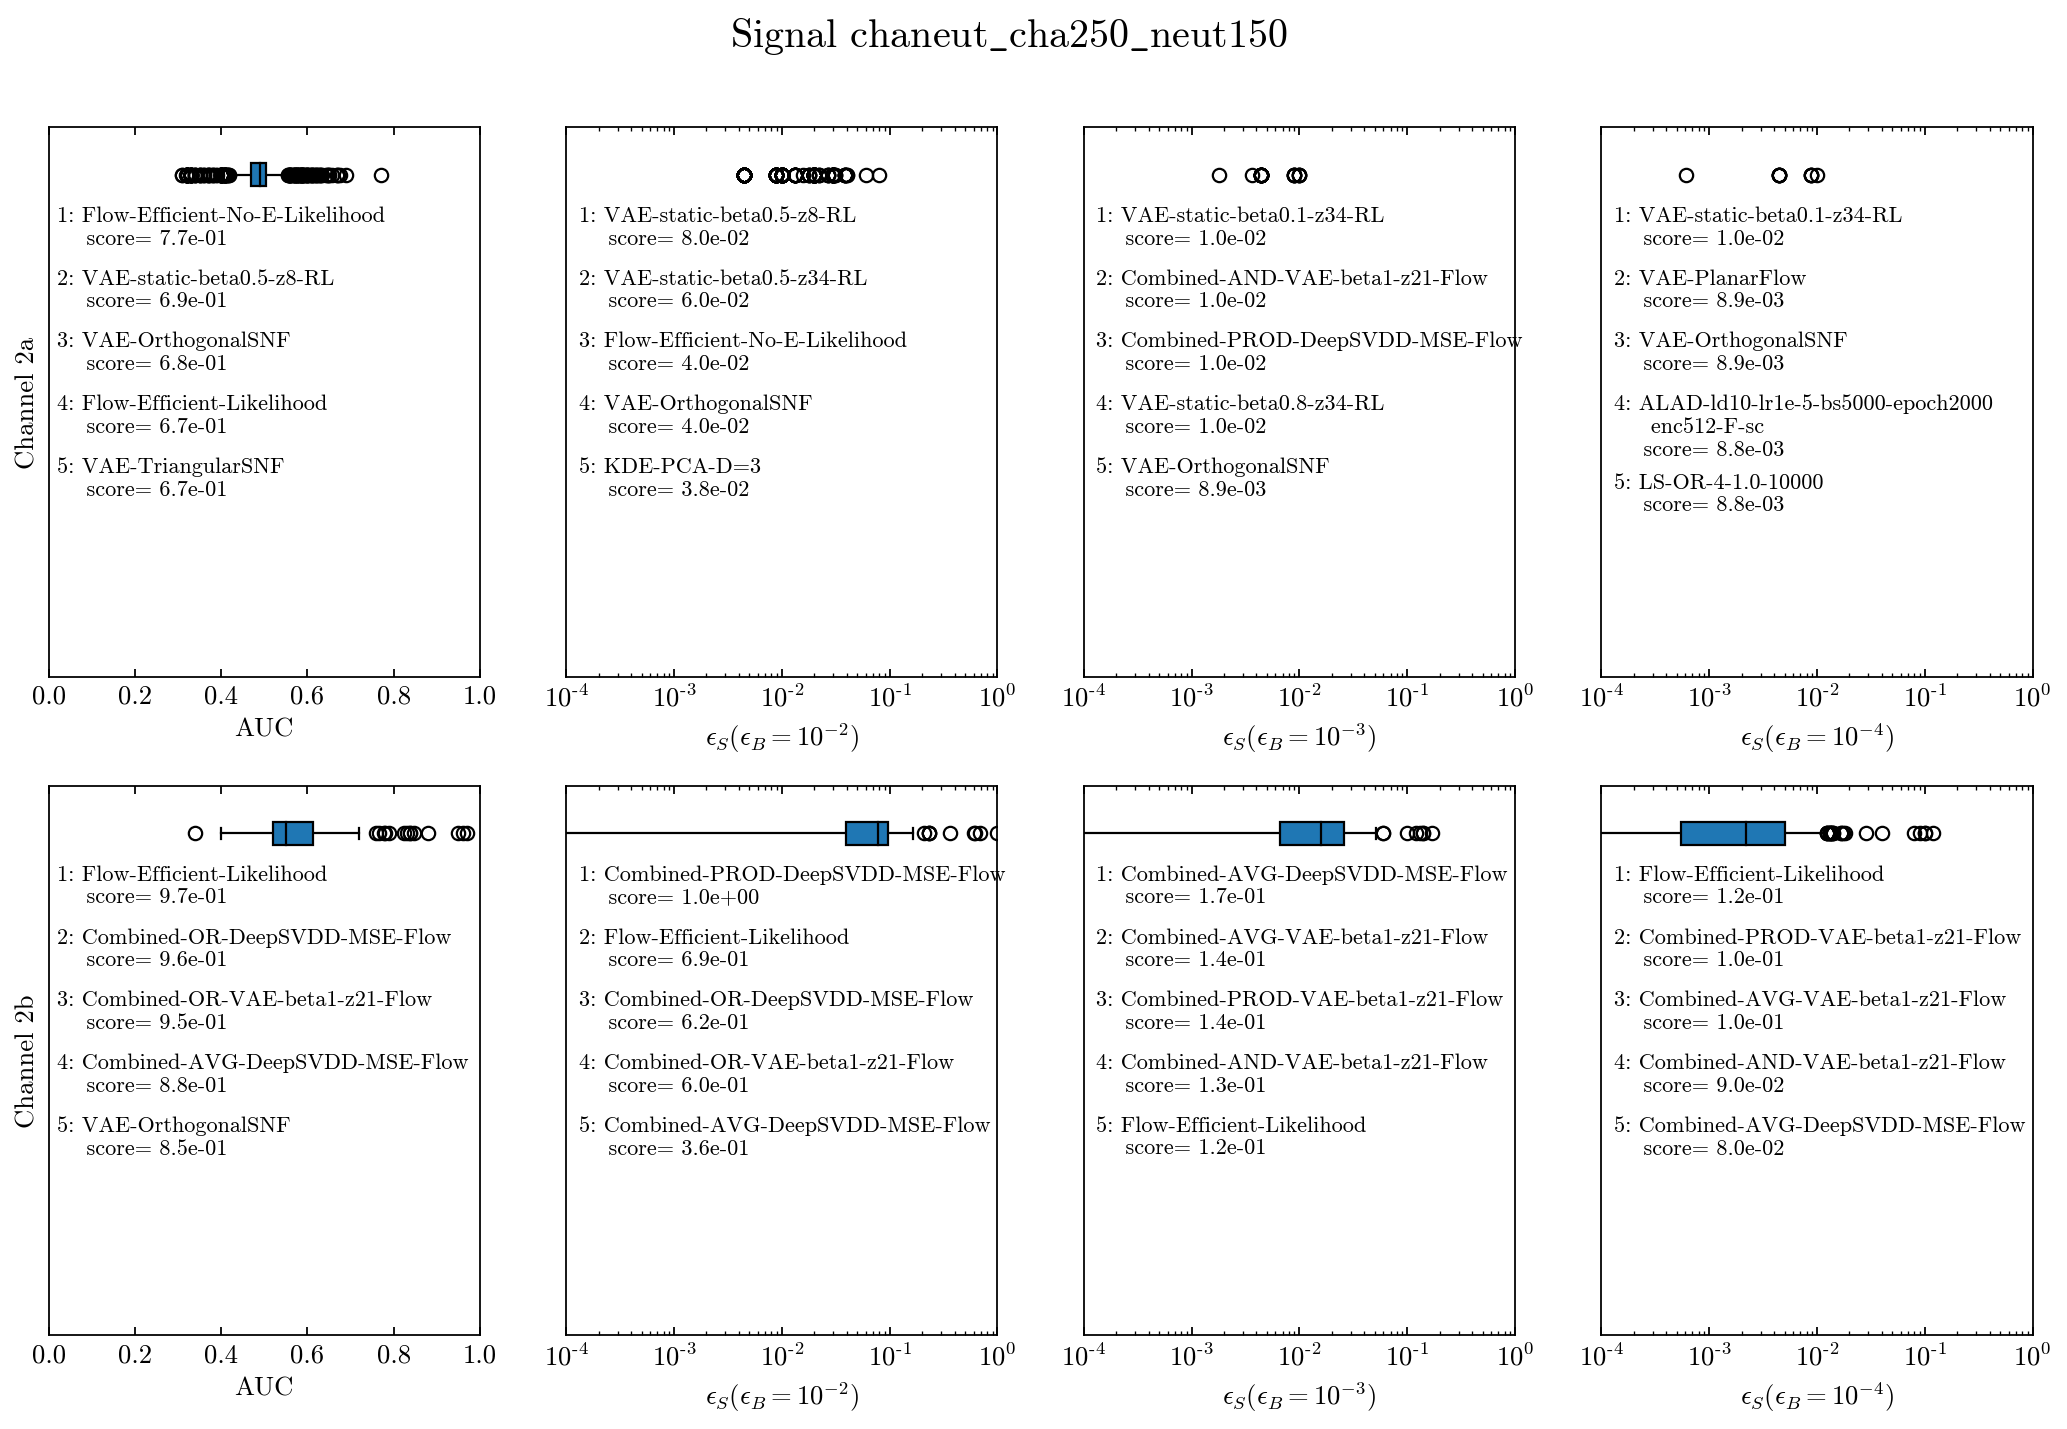

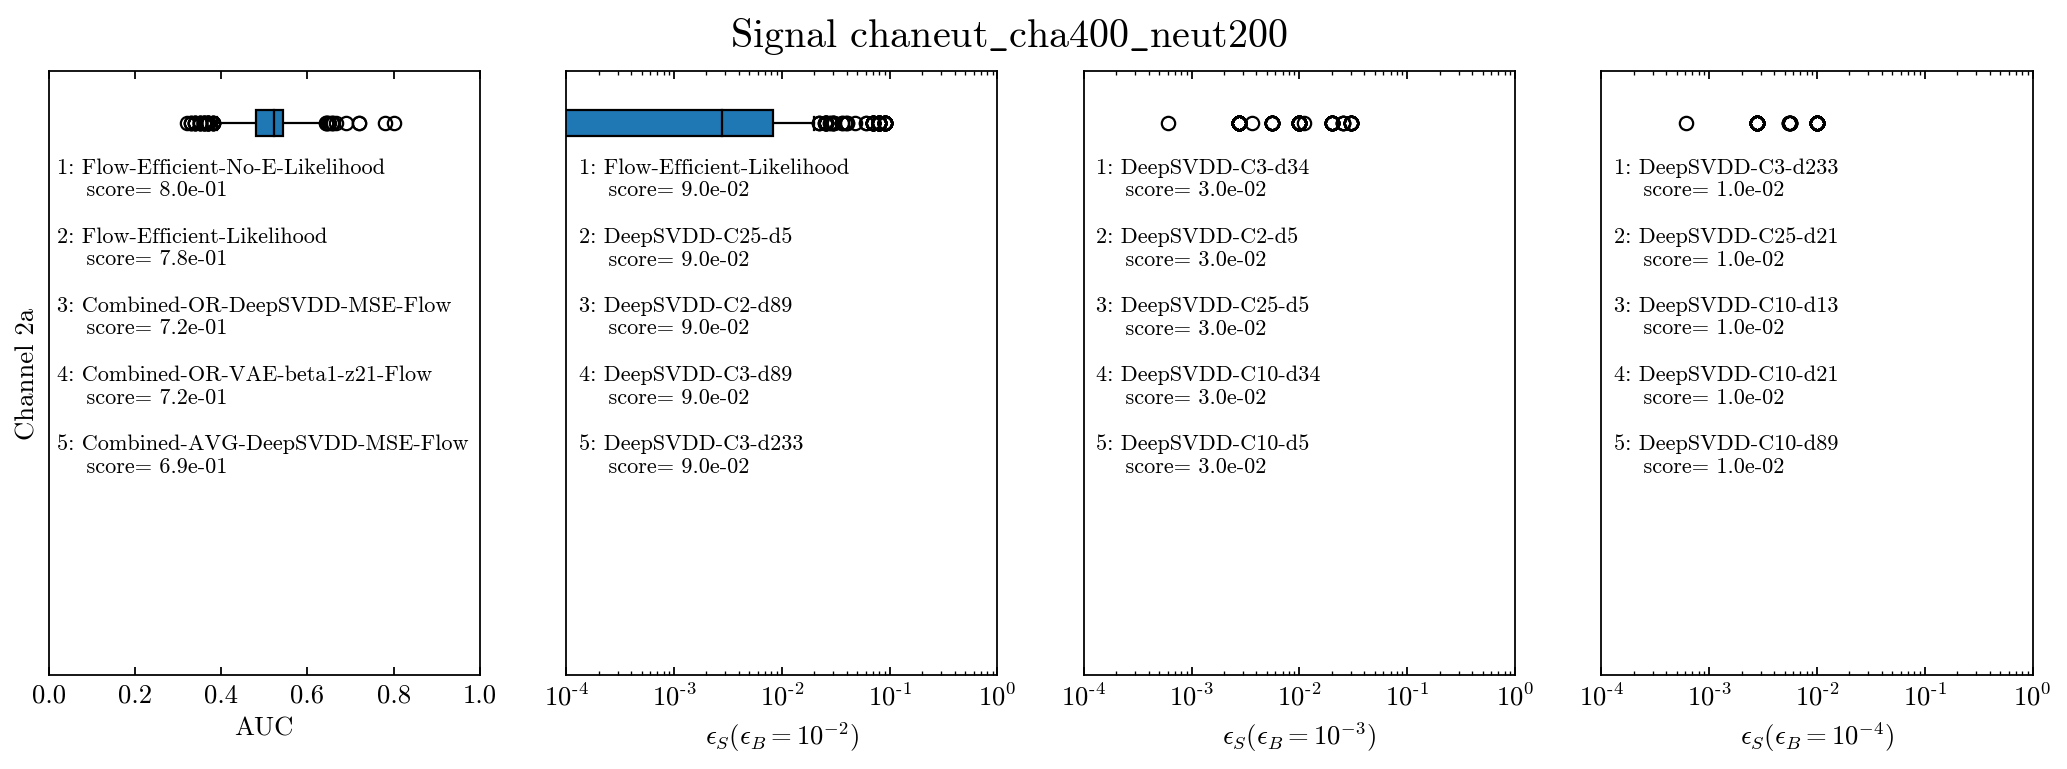

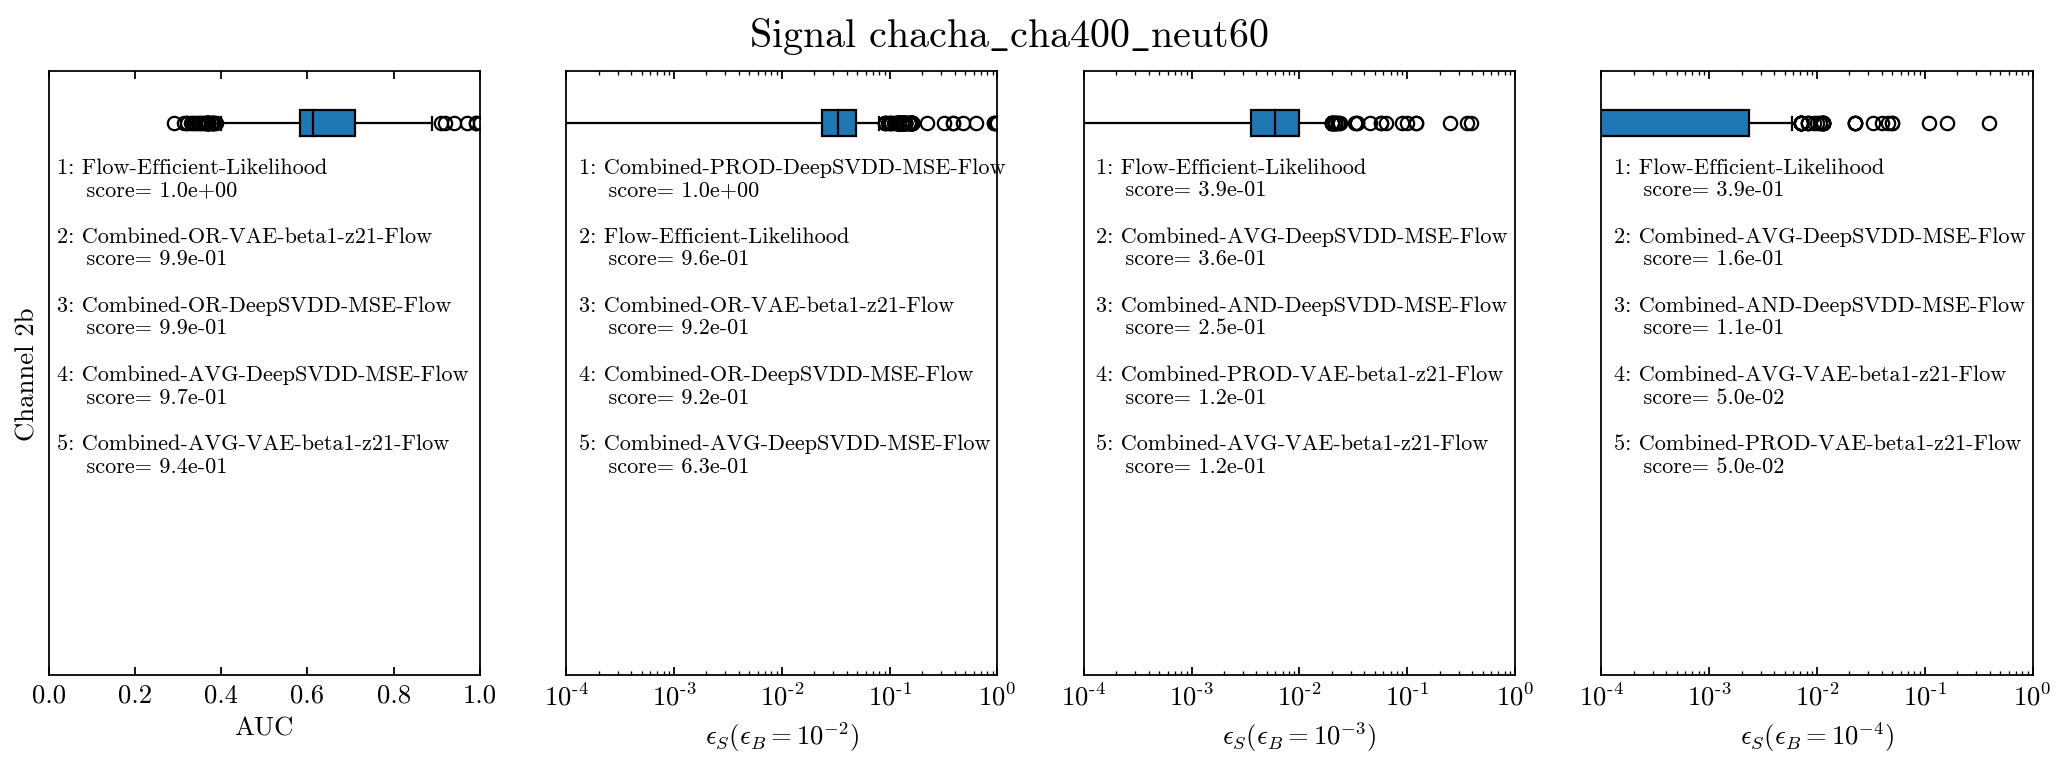

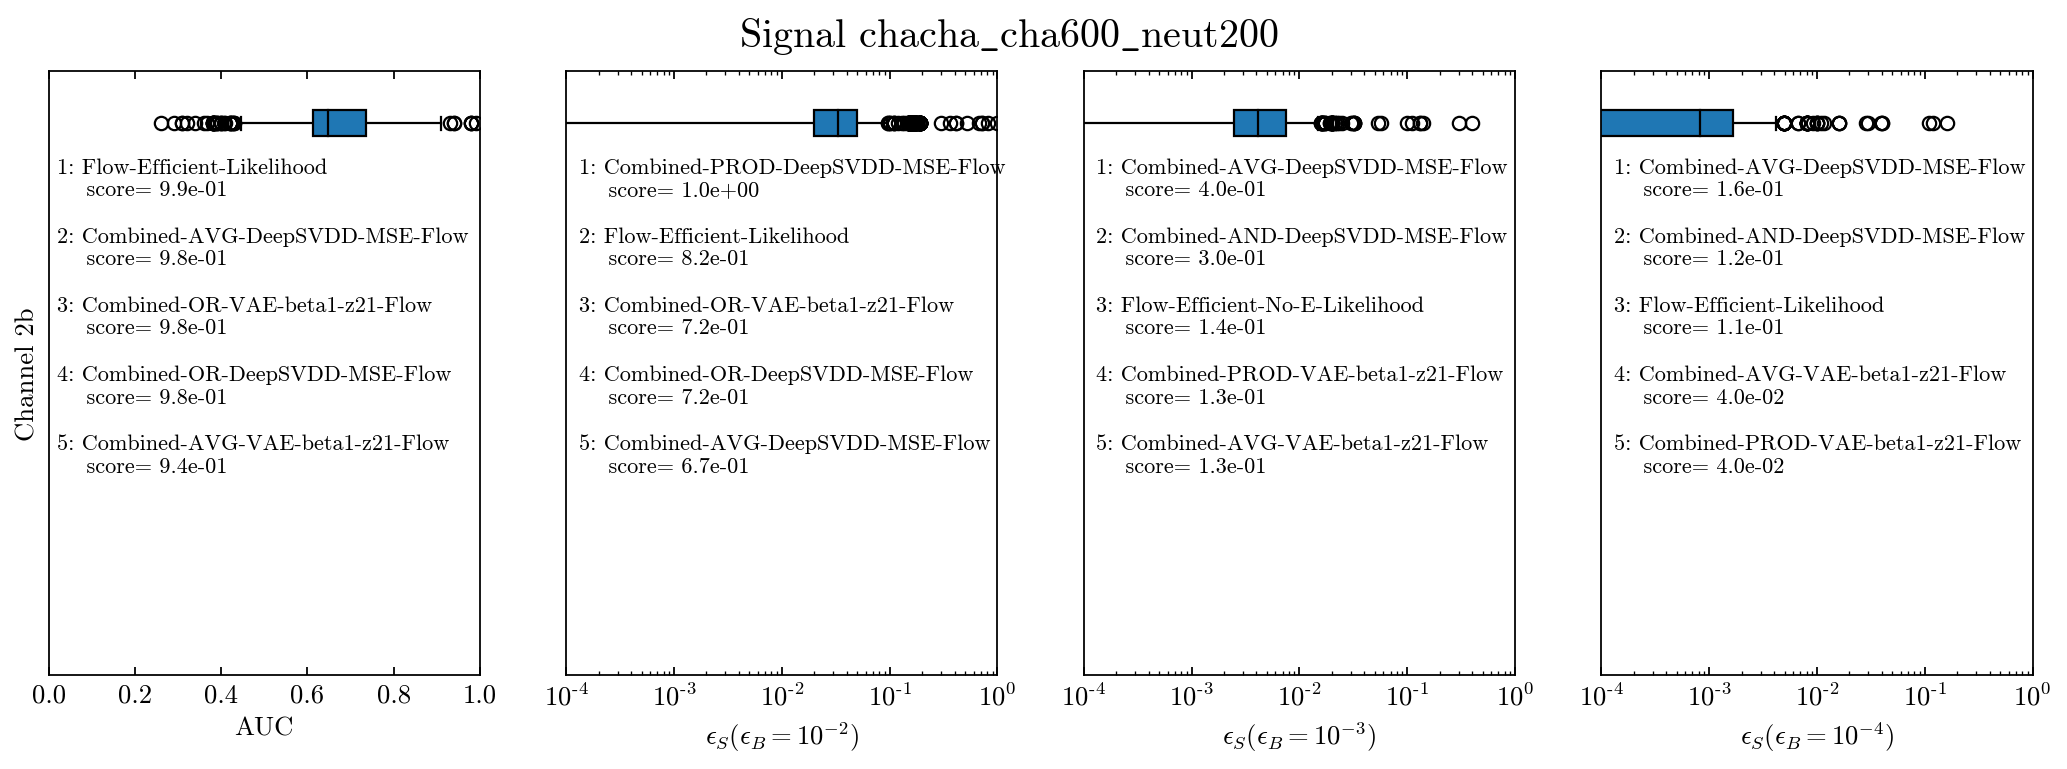

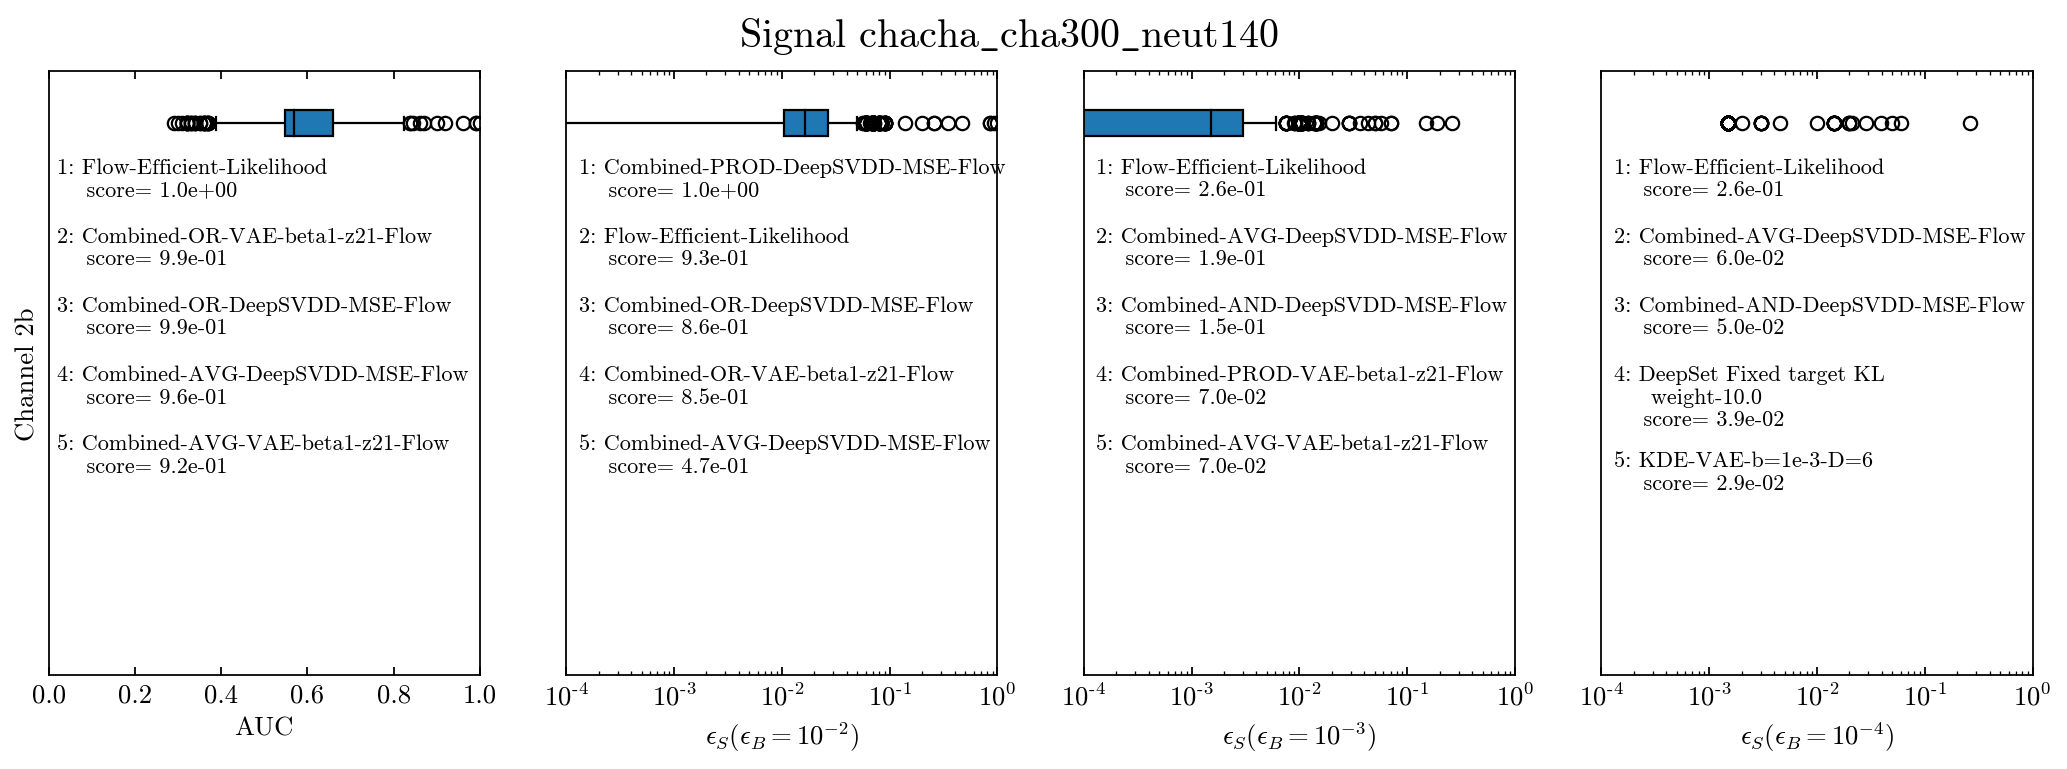

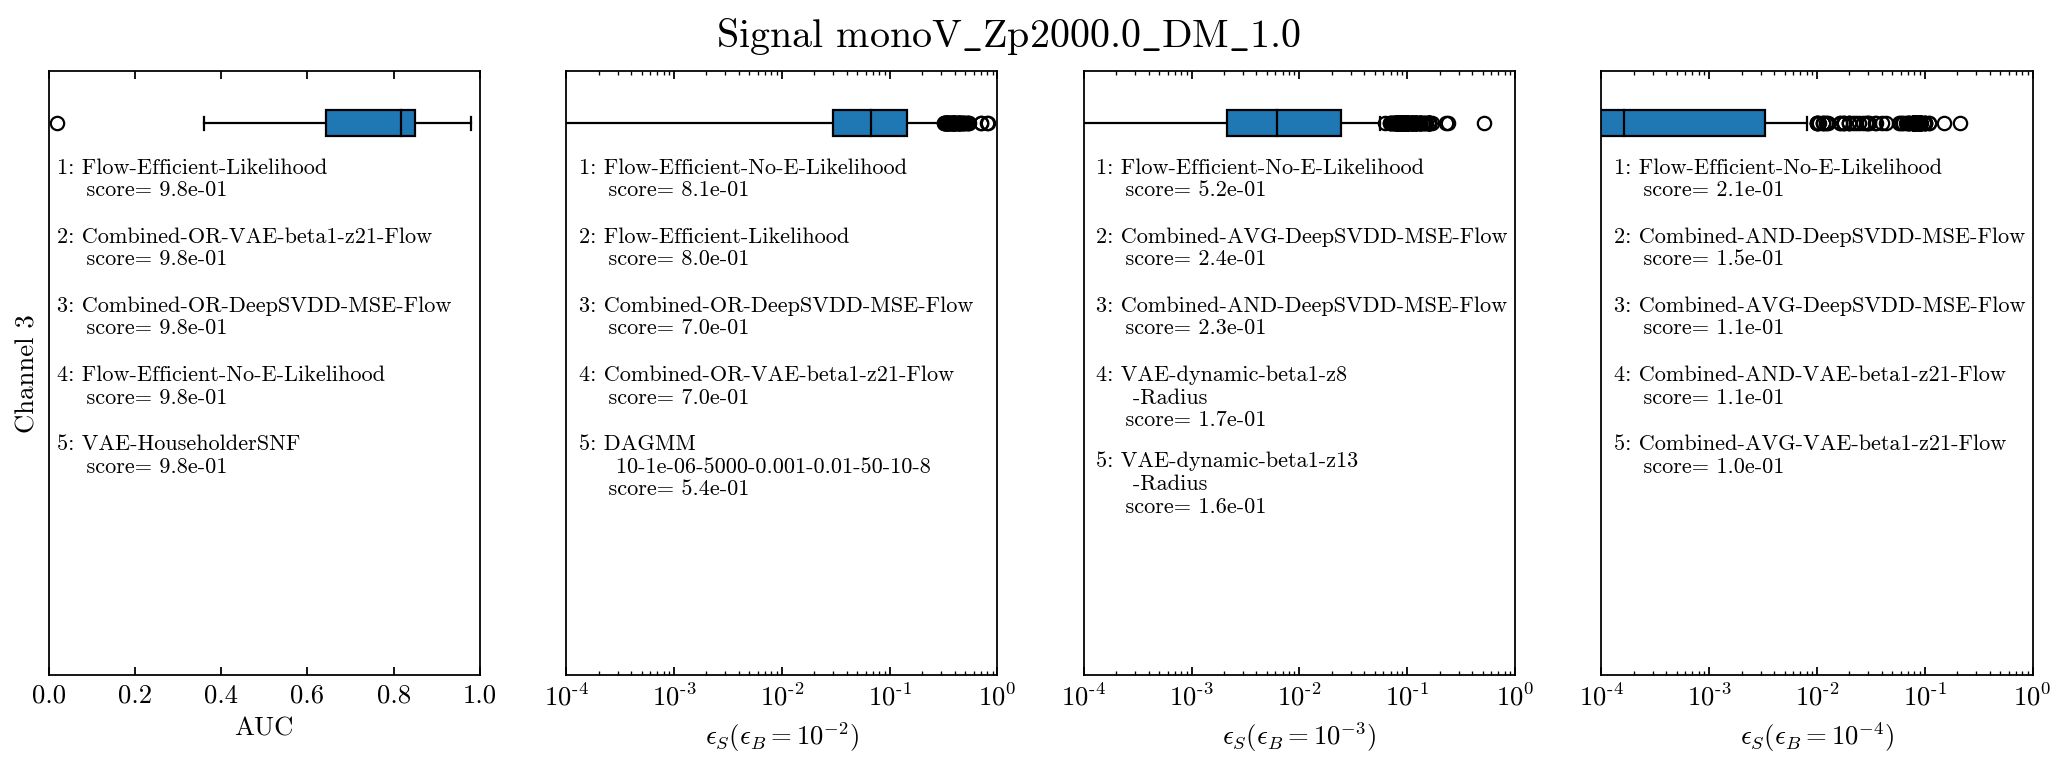

In [21]:
for sig in AllSigs:
    tmp_df = AllCombined[AllCombined['Signal'] == sig]
    channels = list(tmp_df.Chan.unique())
    lc = len(channels)
    plt.figure(figsize=(4*4, 5.*lc))
    gs0 = gs.GridSpec(lc, 4, hspace=0.2)
    
    for i, chan in enumerate(channels):
        tmp_df = AllCombined[(AllCombined['Signal'] == sig) & (AllCombined['Chan'] == chan)]
        for j, metric in enumerate(['AUC', '1e-2', '1e-3', '1e-4']):
            plt.subplot(gs0[(i*4)+j])
            myones = np.ones(len(tmp_df))
            plt.boxplot(np.array(tmp_df[metric]).reshape(-1, 1),
                        vert=False,
                        manage_ticks=False,
                        patch_artist=True,
                        medianprops={'color':'k'},
                        positions=[1.2]
                       )
            top_models = list(tmp_df.sort_values(by=metric, ascending=False)['Model'][:5])
            plt.ylim(-2, 1.5)
            base = 1
            for mn in range(5):
                change = 0.4
                mod = top_models[mn]
                if len(mod.split('+')) == 2:
                    change+=0.2
                elif 'enc' in mod:
                    change+=0.1
                elif 'DeepSet' in mod:
                    change+=0.1
                elif 'Radius' in mod:
                    change+=0.1
                elif 'DAGMM' in mod:
                    change+=0.1
                    
                plt.text(0.02 if metric == 'AUC' else (np.log10(20))*1e-4,
                         base,
                         (f'{mn + 1}: {top_models[mn]}'.replace('+', '\n    ').replace('_','-')).replace('-Fixed target','\n     Fixed target').replace('-enc', '\n     enc').replace(' weight-', '\n     weight-').replace('-weight-', '\n     weight-').replace('-Radius', '\n     -Radius').replace('DAGMM-', 'DAGMM\n     ') + '\n    score=' f" {float(tmp_df[tmp_df['Model']==top_models[mn]][metric]):.1e}",
                         fontsize=10,
                         ha='left',
                         va='top'
                        )
                base -= change
            if metric == 'AUC':
                plt.xlim(0, 1)
                plt.ylabel(f'Channel {chan}')
                plt.xlabel('AUC')
            else:
                plt.xlim(1e-4, 1)
                plt.xscale('log')
                plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
                if metric == '1e-2':
                    plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-2})$')
                if metric == '1e-3':
                    plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-3})$')
                if metric == '1e-4':
                    plt.xlabel(r'$\epsilon_S(\epsilon_B = 10^{-4})$')
            plt.yticks([])
            
    plt.suptitle(f'Signal {sig}'.replace("_", r"$\_$"), fontsize=18, y=0.95)
    
    plt.savefig(f'../figures/indivdual_signals/IndividualSignal_{sig}.pdf', bbox_inches='tight')
    plt.show()
